# decappingQuantification.ipynb
## Marcus Viscardi,    April 15, 2024

Check out `README.md` for a more overarching view of what is happening here.

Specifically, the goal is to produce comparisons of true full-length reads (spanning out to the TSS) and the reads that have cleavages near their stop codons (and the other reads).

The largest choice to make here, is if we want to manually annotate a subset of genes to look at for this, or if we should rather look into a reference-based approach. I think the reference-based approach is likely to be more robust, but it will require a big up-front investment in time to get the reference data in a usable format.

Initially, I think I will start with the manual annotation approach, as it will be quicker to get started with and will allow me to get a better feel for the data and the types of things that I will be looking for.

In [1]:
from typing import Tuple

import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

import re

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from pathlib import Path

from scipy.stats import mannwhitneyu, ks_2samp

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-07-08 13:22:55 | > 'Imports done!'


In [2]:
gtf_parquet_path = Path("/data16/marcus/genomes/plus_cerENO2_elegansRelease100/230327_allChrs_plus-cerENO2.gtf.parquet")

gtf_df = pd.read_parquet(gtf_parquet_path)

current_dir = Path.cwd()

In [3]:
obj_dict = {}
libs_to_run = [
    "oldN2",
    # "oldS6",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    "temp25cN2",
    "temp25cS5",
    "temp25cS6",
    "temp25cS7",
]
for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib)
    obj_dict[lib] = obj
    print(" Done!")
    obj.load_mergedOnReads()
    obj.load_nmd_targets(return_sambamobj=False)


Loading oldN2... Done!
Loading 240219_mergedOnReads.parquet... Done. Loaded 701,680 rows.

Loading newerN2... Done!
Loading 230327_mergedOnReads.plusStandards.parquet... Done. Loaded 1,053,185 rows.

Loading newerS6... Done!
Loading 230403_mergedOnReads.plusStandards.parquet... Done. Loaded 1,226,144 rows.

Loading newerS5... Done!
Loading 230410_mergedOnReads.plusStandards.parquet... Done. Loaded 557,991 rows.

Loading thirdN2... Done!
Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,186,602 rows.

Loading thirdS5... Done!
Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,440,373 rows.

Loading thirdS6... Done!
Loading 230918_mergedOnReads.plusStandards.parquet... Done. Loaded 560,899 rows.

Loading temp25cN2... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 522,716 rows.

Loading temp25cS5... Done!
Loading 240701_mergedOnReads.plusStandards.parquet... Done. Loaded 803,791 rows.

Loading temp25cS6... Done!
Loading 24070

In [4]:
def histo_plot_ends(test_gene, gtf_df, obj_dict, flanking_dist=200):
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    start, end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    print(f"Gene target ({test_gene}) on strand: {strand}")
    
    stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
    start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ax1, ax2 = axes
    
    sea.histplot(data=obj_dict['thirdN2'].mergedOnReads_df.query('gene_name == @test_gene and t5 == 0'),
                 x='chr_pos',
                 binwidth=10,
                 # stat='percent',
                 common_norm=False,
                 ax=ax1,
                 color='k',
                 alpha=0.5)
    ax1.set_ylabel('Unadapted Reads')
    sea.histplot(data=obj_dict['thirdN2'].mergedOnReads_df.query('gene_name == @test_gene and t5 == 1'),
                 x='chr_pos',
                 binwidth=10,
                 # stat='percent',
                 common_norm=False,
                 ax=ax2,
                 color='r',
                 alpha=0.5)
    ax2.set_ylabel('Adapted Reads')
    
    for stop_loc in stop_locations:
        ax1.axvline(stop_loc, color='r', linestyle='--')
        ax2.axvline(stop_loc, color='r', linestyle='--')
    for start_site in start_sites:
        ax1.axvline(start_site, color='g', linestyle='--')
        ax2.axvline(start_site, color='g', linestyle='--')
    
    ax1.set_xlim(start-flanking_dist, end+flanking_dist)
    ax2.set_xlim(start-flanking_dist, end+flanking_dist)
    
    plt.title(test_gene)
    plt.tight_layout()
    plt.show()

genes = [
    'rps-22',
    'ubl-1',
    'rpl-30',
    # 'eef-1A.1',  # rev  # Something weird is going on...
    'rla-1',  # rev
    'rps-25',  # rev
    'Y37E3.8',  # rev
    'rpl-10',
    'rla-0',
    'rpl-18',
    'rps-3',
    'rpl-38',
    'rpl-24.1',
    # NMD Targets:
    # 'rpl-30',
    # 'ubl-1',
    # 'rps-22',
    'hel-1',
    'rpl-7A',
    'ZK228.4',
    'R06C1.4',
    'rpl-12',
    'pqn-70',
    'rsp-5',
    'rpl-1',
    'C53H9.2',
    'rpl-3',
    'rsp-6',
    'rpl-26',
    'K08D12.3',
    'aly-3',
]
for gene_to_plot in genes:
    # histo_plot_ends(gene_to_plot, gtf_df, obj_dict, flanking_dist=100)
    print(gene_to_plot)

rps-22
ubl-1
rpl-30
rla-1
rps-25
Y37E3.8
rpl-10
rla-0
rpl-18
rps-3
rpl-38
rpl-24.1
hel-1
rpl-7A
ZK228.4
R06C1.4
rpl-12
pqn-70
rsp-5
rpl-1
C53H9.2
rpl-3
rsp-6
rpl-26
K08D12.3
aly-3


In [9]:
UNANNOTATED_TSS_DICT = {  # these are manual annotations of stops that are not in the GTF file
    'rpl-7A': [4_390_579, 4_390_464],
}

UNANNOTATED_STOPS_DICT = {  # these are manual annotations of stops that are not in the GTF file
    'rps-22': [1_950_853],
    'rpl-30': [10_436_332],
}

def get_other_read_end(row):
    cigar = row['cigar']
    read_pos = row['chr_pos']
    if cigar is None:
        raise ValueError("Cigar is None!")
    if read_pos is None:
        raise ValueError("read_pos is None!")
    pattern = r"(\d*)([MDISN])"
    matches = re.findall(pattern, cigar)
    for match in matches:
        count, key = match
        if key in ['M', 'D', 'N']:
            read_pos += int(count)
    return read_pos

def near_a_tss_or_stop(row, _strand, tss_positions, stop_positions, col_for_pos='chr_pos', full_window_size=50, window_bias_downstream=0.50, make_window_correction=True) -> Tuple[bool, bool]:
    chr_pos = row[col_for_pos]
    if _strand == '-' and make_window_correction:
        window_bias_downstream = 1 - window_bias_downstream
    elif _strand != '+' and make_window_correction:
        raise ValueError(f"Strand must be '+' or '-' not {_strand}")
    
    near_tss = False
    near_stop = False
    chr_pos_upstream = chr_pos - full_window_size * (1 - window_bias_downstream)
    chr_pos_downstream = chr_pos + full_window_size * window_bias_downstream
    for tss in set(tss_positions):
        if chr_pos_upstream <= tss <= chr_pos_downstream:
            near_tss = True
            break
    for stop in set(stop_positions):
        if chr_pos_upstream <= stop <= chr_pos_downstream:
            near_stop = True
            break
    return near_tss, near_stop

def convert_near_tss_and_stop_to_hue(row, tss_color='g', stop_color='r', neither_color='k', both_color='y'):
    near_tss, near_stop = row['near_tss'], row['near_stop']
    if near_tss and near_stop:
        return both_color
    elif near_tss:
        return tss_color
    elif near_stop:
        return stop_color
    else:
        return neither_color

def plot_gene_data(gtf_df, test_gene, plot_lib_objs_dict, window_size=60,
                   up_v_down_fraction=0.25, number_of_bins=40,
                   flanking_gene_fraction=0.05, current_dir=None, print_stats=False,
                   title_override=None, save_name_override=None):
    
    extra_stops_dict = UNANNOTATED_STOPS_DICT
    
    extra_tss_dict = UNANNOTATED_TSS_DICT
    
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    gene_start, gene_end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    gene_length = gene_end - gene_start
    bin_width = gene_length / number_of_bins
    flanking_dist = int(gene_length * flanking_gene_fraction)
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    if print_stats:
        print(f"Gene target ({test_gene}) on strand: {strand}")
    if strand == '-':
        if print_stats:
            print("Because this gene is on the reverse strand, we will have to calculate out the other end of the reads with the CIGAR strings. This will take slightly longer.")
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'end'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'end'].values
        up_v_down_fraction = 1 - up_v_down_fraction
        flipped = True
    else:
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
        flipped = False
        
    stop_locations = list(stop_locations)
    start_sites = list(start_sites)
    
    if test_gene in extra_stops_dict:
        for stop_location in extra_stops_dict[test_gene]:
            stop_locations.append(stop_location)
    if test_gene in extra_tss_dict:
        for tss_location in extra_tss_dict[test_gene]:
            start_sites.append(tss_location)
    
    fig = plt.figure(figsize=(11, 1.5 * len(plot_lib_objs_dict)))
    
    gs = fig.add_gridspec(len(plot_lib_objs_dict), 5,
                          width_ratios=[4, 4, 1, 1, 1.5],
                          ) 
    
    for i, (lib, lib_obj) in enumerate(plot_lib_objs_dict.items()):

        if print_stats:
            print(f"\t{lib}:")
        ax1, ax2, ax3, ax4, ax5 = [fig.add_subplot(gs[i, j]) for j in range(5)]
        
        if i == 0:
            ax1.set_title("Unadapted 5' Ends")
            ax2.set_title("Adapted 5' Ends")
            ax3.set_title("Near TSS")
            ax4.set_title("Near Stop")
            ax5.set_title("Lib Stats")
        
        gene_df = lib_obj.mergedOnReads_df.query('gene_name == @test_gene').copy()
        gene_df.replace({'t5': {0: '-', 1: '+', '+': '+', '-': '-'}}, inplace=True)
        if flipped:
            gene_df.loc[:, 'chr_pos'] = gene_df.apply(get_other_read_end, axis=1)
        gene_df.loc[:, 'near_tss'], gene_df.loc[:, 'near_stop'] = zip(*gene_df.apply(near_a_tss_or_stop, args=(strand, start_sites, stop_locations),
            full_window_size=window_size, window_bias_downstream=up_v_down_fraction, axis=1))
        gene_df.loc[:, 'hue'] = gene_df.apply(convert_near_tss_and_stop_to_hue, axis=1)
        
        unadapted_df = gene_df.query('t5 == 0 or t5 == "-"')
        unadapted_value_counts = unadapted_df['near_tss'].value_counts(normalize=True)
        if print_stats:
            print(f"\t\tUnadapted Read Distribution (near a TSS):")
            print(f"\t\t\t True: {unadapted_value_counts.get(True, 0.0):%}")
            print(f"\t\t\tFalse: {unadapted_value_counts.get(False, 0.0):%}")
        if not unadapted_df.empty:
            sea.histplot(data=unadapted_df,
                         x='chr_pos',
                         hue='hue',
                         palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                         binwidth=bin_width,
                         ax=ax1,
                         edgecolor='k', linewidth=1.0,
                         )
            ax1.get_legend().remove()
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_tss'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'g', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax3,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax3.set_ylabel ("") # ("% Near TSS")
            ax3.get_legend().remove()
        else:
            ax1.text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
            print(lib_obj.mergedOnReads_df.query('gene_name == @test_gene').head())
        ax1.set_ylabel(f"-- {lib} --")
        
        adapted_df = gene_df.query('t5 == 1 or t5 == "+"')
        adapted_value_counts = adapted_df['near_stop'].value_counts(normalize=True)
        if print_stats:
            print(f"\t\tAdapted Read Distribution (near a STOP):")
            print(f"\t\t\t True: {adapted_value_counts.get(True, 0.0):%}")
            print(f"\t\t\tFalse: {adapted_value_counts.get(False, 0.0):%}")
        if not adapted_df.empty:
            sea.histplot(data=adapted_df,
                         x='chr_pos',
                         hue='hue',
                         palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                         binwidth=bin_width,
                         ax=ax2,
                         edgecolor='k', linewidth=1.0,
                         )
            ax2.get_legend().remove()
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_stop'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'r', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax4,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax4.set_ylabel("")  #("% Near Stop")
            ax4.get_legend().remove()
        else:
            ax2.text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
        ax2.set_ylabel(f"")
        
        ax1.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
        ax2.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
        ax1.set_xlabel(f"")
        ax2.set_xlabel(f"")
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        
        ax3.set_xlabel(f"")
        ax4.set_xlabel(f"")
        ax3.set_xticklabels(['Unad', 'Ad'], rotation=0)
        ax4.set_xticklabels(['Unad', 'Ad'], rotation=0)
        
        precompute_transforms = {ax1: ax1.get_xaxis_transform(),
                                 ax2: ax2.get_xaxis_transform()}
        for stop_loc in set(stop_locations):
            for ax in [ax1, ax2]:
                ax.axvline(stop_loc, color='r', linestyle='--', alpha=0.5)
                ax.axvspan(stop_loc-window_size*up_v_down_fraction,
                           stop_loc+window_size*(1-up_v_down_fraction),
                           color='r', alpha=0.1)
                blend_transform = precompute_transforms[ax]
                ax.text(stop_loc, -0.1, "*", rotation=0,
                        verticalalignment='top', horizontalalignment='center',
                        transform=blend_transform,
                        fontsize=14)
        for start_site in set(start_sites):
            for ax in [ax1, ax2]:
                ax.axvline(start_site, color='g', linestyle='--', alpha=0.5)
                ax.axvspan(start_site-window_size*up_v_down_fraction,
                           start_site+window_size*(1-up_v_down_fraction),
                           color='g', alpha=0.1)
                blend_transform = precompute_transforms[ax]
                if flipped:
                    tss_icon = "<"
                else:
                    tss_icon = ">"
                ax.text(start_site, -0.05, tss_icon, rotation=0,
                        verticalalignment='top', horizontalalignment='center',
                        transform=blend_transform,
                        fontsize=12)
        
        
                # Create annotations to put in ax5
        ada_near_stop_count = adapted_df.query('near_stop').shape[0]
        ada_near_tss_count = adapted_df.query('near_tss').shape[0]
        unada_near_stop_count = unadapted_df.query('near_stop').shape[0]
        unada_near_tss_count = unadapted_df.query('near_tss').shape[0]
        ada_total_count = adapted_df.shape[0]
        unada_total_count = unadapted_df.shape[0]
        ada_stop_over_FL_string = f"{ada_near_stop_count}/{unada_near_tss_count} ({ada_near_stop_count/unada_near_tss_count:.2%})"
        ada_tss_over_FL_string = f"{ada_near_tss_count}/{unada_near_tss_count} ({ada_near_tss_count/unada_near_tss_count:.2%})"
        ax5.axis('off')
        plot_string = (
            f"Adapted Near Stop:   {ada_near_stop_count}\n"
            f"Adapted Near TSS:    {ada_near_tss_count}\n"
            f"Total Adapted:       {ada_total_count}\n"
            f"Unadapted Near Stop: {unada_near_stop_count}\n"
            f"Unadapted Near TSS:  {unada_near_tss_count}\n"
            f"Total Unadapted:     {unada_total_count}\n"
            f"Ada Stop/Unada FL: {ada_stop_over_FL_string}\n"
            f"Ada  TSS/Unada FL: {ada_tss_over_FL_string}"
        )
        ax5.text(-0.5, 0.4, plot_string,
                 fontsize=8,
                 fontfamily='monospace',
                 horizontalalignment='left',
                 verticalalignment='center',
                 # transform=ax5.transAxes,
                 )
    if isinstance(title_override, str):
        plt.suptitle(title_override)
    else:
        plt.suptitle(f"{test_gene} ({strand} strand)")
    plt.tight_layout()
    if current_dir is not None:
        if isinstance(save_name_override, str):
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.svg")
        else:
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.svg")
    plt.show()

# plot_libs = [
#     'oldN2',
#     'newerN2',
#     'newerS6',
#     'newerS5',
#     'thirdN2',
#     'thirdS5',
#     'thirdS6',
#     'temp25cN2',
#     'temp25cS5',
#     'temp25cS6',
#     'temp25cS7',
# ]

plot_libs = libs_to_run

plot_lib_objs_dict = {lib: obj_dict[lib] for lib in plot_libs}

plot_genes = genes[:]

for test_gene in plot_genes[:]:
    print(f"{test_gene:#^50}")
    try:
        # plot_gene_data(gtf_df, test_gene, plot_lib_objs_dict, current_dir=current_dir, print_stats=False)
        pass
    except Exception as e:
        print(f"Error: {e}")
        continue

######################rps-22######################
######################ubl-1#######################
######################rpl-30######################
######################rla-1#######################
######################rps-25######################
#####################Y37E3.8######################
######################rpl-10######################
######################rla-0#######################
######################rpl-18######################
######################rps-3#######################
######################rpl-38######################
#####################rpl-24.1#####################
######################hel-1#######################
######################rpl-7A######################
#####################ZK228.4######################
#####################R06C1.4######################
######################rpl-12######################
######################pqn-70######################
######################rsp-5#######################
######################rpl-1####

In [10]:
gene_ids_to_names_dict = gtf_df.query('feature == "gene"').set_index('gene_id')['gene_name'].to_dict()
gene_names_to_ids_dict = gtf_df.query('feature == "gene"').set_index('gene_name')['gene_id'].to_dict()
for gene_name in plot_genes:
    gene_id = gene_names_to_ids_dict[gene_name]
    print(f"{gene_name:>10} -> {gene_id}")
gene_ids = [gene_names_to_ids_dict[gene_name] for gene_name in plot_genes]

    rps-22 -> WBGene00004491
     ubl-1 -> WBGene00006725
    rpl-30 -> WBGene00004444
     rla-1 -> WBGene00004409
    rps-25 -> WBGene00004494
   Y37E3.8 -> WBGene00021350
    rpl-10 -> WBGene00004421
     rla-0 -> WBGene00004408
    rpl-18 -> WBGene00004430
     rps-3 -> WBGene00004472
    rpl-38 -> WBGene00004452
  rpl-24.1 -> WBGene00004436
     hel-1 -> WBGene00001840
    rpl-7A -> WBGene00004419
   ZK228.4 -> WBGene00013947
   R06C1.4 -> WBGene00011059
    rpl-12 -> WBGene00004424
    pqn-70 -> WBGene00004152
     rsp-5 -> WBGene00004702
     rpl-1 -> WBGene00004412
   C53H9.2 -> WBGene00016907
     rpl-3 -> WBGene00004414
     rsp-6 -> WBGene00004703
    rpl-26 -> WBGene00004440
  K08D12.3 -> WBGene00019537
     aly-3 -> WBGene00000122


In [11]:
import pysam

def load_simple_nmd_targets(nmd_targets_path, target_gene_ids_to_names_dict) -> pd.DataFrame:
    target_gene_names_to_ids_dict = {v: k for k, v in target_gene_ids_to_names_dict.items()}
    reads_dict = {}
    with pysam.AlignmentFile(nmd_targets_path, 'rb') as test_bam:
        for read in test_bam.fetch():
            read_assigned_gene_id = read.get_tag('gA')
            # print(read.query_name, read_assigned_gene_id, target_gene_ids_to_names_dict[read_assigned_gene_id], read.get_tag('t5'), read.get_tag('nC'))
            reads_dict[read.query_name] = {
                'gene_id': read_assigned_gene_id,
                'gene_name': target_gene_ids_to_names_dict[read_assigned_gene_id],
                't5': read.get_tag('t5'),
                'nmd_assignment': read.get_tag('nC'),
                'cigar': read.cigarstring,
                'chr_pos': read.reference_start,
                'chr': read.reference_name,
                'seq': read.query_sequence,
            }
    df = pd.DataFrame(reads_dict).T
    return df

nmd_genes = []

for lib, lib_obj in obj_dict.items():
    print(f"Loading {lib} NMD Targets from {lib_obj.nmd_targets_bam_path}...", end="")
    lib_obj.load_nmd_targets(return_sambamobj=False)
    print(" Done!")
    lib_obj.nmd_targets_df = load_simple_nmd_targets(lib_obj.nmd_targets_bam_path, gene_ids_to_names_dict)
    # print(lib_obj.nmd_targets_df.gene_name.unique())
    nmd_genes.extend(lib_obj.nmd_targets_df.gene_name.unique())
nmd_genes = list(set(nmd_genes))
print(nmd_genes)

Loading oldN2 NMD Targets from /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerN2 NMD Targets from /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerS6 NMD Targets from /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading newerS5 NMD Targets from /data16/marcus/working/230410_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA_rerun/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading thirdN2 NMD Targets from /data16/marcus/working/230918_nanoporeRun_sMV013_wt_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_targets.all.merge.bam... Done!
Loading thirdS5 NMD Targets from /data16/marcus/working/230918_nanoporeRun_sMV014_smg-5_xrn-1-KD_5TERA/output_dir/NMD_targets/240702_nmd_target

In [13]:
UNANNOTATED_TSS_DICT = {  # these are manual annotations of transcription start sites that are not in the GTF file
    'rpl-7A': [4_390_579, 4_390_464],
}

UNANNOTATED_STOPS_DICT = {  # these are manual annotations of stops that are not in the GTF file
    'rps-22': [1_950_853],  # cassette exon contains PTC
    'rpl-30': [10_436_332],  # extension of first exon contains PTC
    'rpl-7A': [4_389_880, 4_389_745],  # unannotated extension of 3rd exon contains PTC (second loc due to potential FS)
    'rsp-6': [7_790_576],  # longer unannotated form of cassette exon causes frame shift
    'C53H9.2': [1_833_467],  # shorter first exon leaves frame shift
    'pqn-70': [11_226_879],  # skipped exon leads to a frame change
    'rpl-1': [2_875_908],  # new orf started in the 3' extension of the first exon, causing a frame change
    'R06C1.4': [11_931_081],  # unannotated cassette exon contains a frame shift
    'rpl-3': [3_868_335],  # incorrectly annotated first intron 3' truncation (2nd exon extended) contains stop
    'hel-2': [8_327_970],  # later 5' SS adds to 3rd exon and contains PTC
    'rpl-12': [13_240_078],  # later 5' SS of second intron adds extension to 2nd exon with a PTC
    'aly-3': [12_123_859], # huge extension of second exon contains as PTC
}

def plot_gene_data3(gtf_df, test_gene, plot_lib_df_dict, window_size=100,
                   up_v_down_fraction=0.10, number_of_bins=40,
                   flanking_gene_fraction=0.05, current_dir=None, print_stats=False,
                   title_override=None, save_name_override=None, show_plot=True):
    
    min_reads_cutoff = 3
    
    extra_stops_dict = UNANNOTATED_STOPS_DICT
    extra_tss_dict = UNANNOTATED_TSS_DICT
    
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    gene_start, gene_end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    gene_length = gene_end - gene_start
    bin_width = gene_length / number_of_bins
    flanking_dist = int(gene_length * flanking_gene_fraction)
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    if print_stats:
        print(f"Gene target ({test_gene}) on strand: {strand}")
    if strand == '-':
        if print_stats:
            print("Because this gene is on the reverse strand, we will have to calculate out the other end of the reads with the CIGAR strings. This will take slightly longer.")
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'end'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'end'].values
        up_v_down_fraction = 1 - up_v_down_fraction
        flipped = True
    elif strand == '+':
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
        flipped = False
    else:
        raise ValueError(f"Strand must be '+' or '-' not '{strand}'")
        
    stop_locations = list(stop_locations)
    start_sites = list(start_sites)
    
    if test_gene in extra_stops_dict:
        for stop_location in extra_stops_dict[test_gene]:
            stop_locations.append(stop_location)
    if test_gene in extra_tss_dict:
        for tss_location in extra_tss_dict[test_gene]:
            start_sites.append(tss_location)
    
    fig = plt.figure(figsize=(11, 1.5 * len(plot_lib_df_dict)))
    
    gs = fig.add_gridspec(len(plot_lib_df_dict), 5,
                          width_ratios=[4, 4, 1, 1, 1.5],
                          )
    summary_dict = {}
    for i, (lib, lib_df) in enumerate(plot_lib_df_dict.items()):

        if print_stats:
            print(f"\t{lib}:")
        ax1, ax2, ax3, ax4, ax5 = [fig.add_subplot(gs[i, j]) for j in range(5)]
        
        if i == 0:
            ax1.set_title("Unadapted 5' Ends")
            ax2.set_title("Adapted 5' Ends")
            ax3.set_title("Near TSS")
            ax4.set_title("Near Stop")
            ax5.set_title("Lib Stats")
        
        gene_df = lib_df.query('gene_name == @test_gene').copy()
        gene_df.replace({'t5': {0: '-', 1: '+', '+': '+', '-': '-'}}, inplace=True)
        if flipped:
            gene_df.loc[:, 'chr_pos'] = gene_df.apply(get_other_read_end, axis=1)
        gene_df.loc[:, 'near_tss'], gene_df.loc[:, 'near_stop'] = zip(*gene_df.apply(near_a_tss_or_stop, args=(strand, start_sites, stop_locations),
            full_window_size=window_size,window_bias_downstream=up_v_down_fraction, make_window_correction=False, axis=1))
        gene_df.loc[:, 'hue'] = gene_df.apply(convert_near_tss_and_stop_to_hue, axis=1)
        
        unadapted_df = gene_df.query('t5 == "-"').copy()
        adapted_df = gene_df.query('t5 == "+"').copy()
        
        # Create annotations to put in ax5
        ada_near_stop_count = adapted_df.query('near_stop').shape[0]
        ada_near_tss_count = adapted_df.query('near_tss').shape[0]
        unada_near_stop_count = unadapted_df.query('near_stop').shape[0]
        unada_near_tss_count = unadapted_df.query('near_tss').shape[0]
        ada_total_count = adapted_df.shape[0]
        unada_total_count = unadapted_df.shape[0]
        try:
            ada_stop_over_FL_string = f"{ada_near_stop_count}/{unada_near_tss_count} ({ada_near_stop_count/unada_near_tss_count:.2%})"
            ada_tss_over_FL_string = f"{ada_near_tss_count}/{unada_near_tss_count} ({ada_near_tss_count/unada_near_tss_count:.2%})"
        except ZeroDivisionError:
            ada_stop_over_FL_string = f"{ada_near_stop_count}/{unada_near_tss_count} (X.XX%)"
            ada_tss_over_FL_string = f"{ada_near_tss_count}/{unada_near_tss_count} (X.XX%)"
        ax5.axis('off')
        plot_string = (
            f"Adapted Near Stop:   {ada_near_stop_count}\n"
            f"Adapted Near TSS:    {ada_near_tss_count}\n"
            f"Total Adapted:       {ada_total_count}\n"
            f"Unadapted Near Stop: {unada_near_stop_count}\n"
            f"Unadapted Near TSS:  {unada_near_tss_count}\n"
            f"Total Unadapted:     {unada_total_count}\n"
            f"Ada Stop/Unada FL: {ada_stop_over_FL_string}\n"
            f"Ada  TSS/Unada FL: {ada_tss_over_FL_string}"
        )
        summary_dict[lib] = {
            'Adapted Near Stop': ada_near_stop_count,
            'Adapted Near TSS': ada_near_tss_count,
            'Total Adapted': ada_total_count,
            'Unadapted Near Stop': unada_near_stop_count,
            'Unadapted Near TSS': unada_near_tss_count,
            'Total Unadapted': unada_total_count,
        }
        try:
            unadapted_value_counts = unadapted_df['near_tss'].value_counts(normalize=True)
            if print_stats:
                print(f"\t\tUnadapted Read Distribution (near a TSS):")
                print(f"\t\t\t True: {unadapted_value_counts.get(True, 0.0):%}")
                print(f"\t\t\tFalse: {unadapted_value_counts.get(False, 0.0):%}")
            if unadapted_df.shape[0] > min_reads_cutoff:
                sea.histplot(data=unadapted_df,
                             x='chr_pos',
                             hue='hue',
                             palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                             binwidth=bin_width,
                             ax=ax1,
                             edgecolor='k', linewidth=1.0,
                             )
                ax1.get_legend().remove()
            else:
                ax1.text(0.5, 0.5, "Insufficient Reads\nFor Plotting", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
                print(lib_obj.mergedOnReads_df.query('gene_name == @test_gene').head())
            ax1.set_ylabel(f"-- {lib} --")
            
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_tss'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'g', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax3,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax3.set_ylabel ("") # ("% Near TSS")
            ax3.get_legend().remove()
            
            adapted_value_counts = adapted_df['near_stop'].value_counts(normalize=True)
            if print_stats:
                print(f"\t\tAdapted Read Distribution (near a STOP):")
                print(f"\t\t\t True: {adapted_value_counts.get(True, 0.0):%}")
                print(f"\t\t\tFalse: {adapted_value_counts.get(False, 0.0):%}")
            if adapted_df.shape[0] > min_reads_cutoff:
                sea.histplot(data=adapted_df,
                             x='chr_pos',
                             hue='hue',
                             palette={'r': 'r', 'g': 'g', 'k': 'k', 'y': 'y'},
                             binwidth=bin_width,
                             ax=ax2,
                             edgecolor='k', linewidth=1.0,
                             )
                ax2.get_legend().remove()
            else:
                ax2.text(0.5, 0.5, "Insufficient Reads\nFor Plotting", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
            
            ax2.set_ylabel(f"")
            
            data_ct = pd.crosstab(index=gene_df['t5'], columns=gene_df['near_stop'])
            data_ct = data_ct.div(data_ct.sum(axis=1), axis=0) * 100
            data_ct.sort_index(ascending=False, inplace=True)
            
            color_dict = {True: 'r', False: 'k', None: 'y'}
            try:
                data_ct.plot(kind='bar',
                             stacked=True,
                             ax=ax4,
                             color=[color_dict[col] for col in data_ct.columns],
                             )
            except ValueError as e:
                print(f"Error: {e}")
                print(data_ct)
            ax4.set_ylabel("")
            ax4.get_legend().remove()
            
            ax1.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
            ax2.set_xlim(gene_start-flanking_dist, gene_end+flanking_dist)
            ax1.set_xlabel(f"")
            ax2.set_xlabel(f"")
            ax1.set_xticklabels([])
            ax2.set_xticklabels([])
            
            ax3.set_xlabel(f"")
            ax4.set_xlabel(f"")
            ax3.set_xticks([0 ,1], labels=['Unad', 'Ad'], rotation=0)
            ax4.set_xticks([0 ,1], labels=['Unad', 'Ad'], rotation=0)
            
            precompute_transforms = {ax1: ax1.get_xaxis_transform(),
                                     ax2: ax2.get_xaxis_transform()}
            for stop_loc in set(stop_locations):
                for ax in [ax1, ax2]:
                    ax.axvline(stop_loc, color='r', linestyle='--', alpha=0.5)
                    ax.axvspan(stop_loc-window_size*up_v_down_fraction,
                               stop_loc+window_size*(1-up_v_down_fraction),
                               color='r', alpha=0.1)
                    blend_transform = precompute_transforms[ax]
                    ax.text(stop_loc, -0.1, "*", rotation=0,
                            verticalalignment='top', horizontalalignment='center',
                            transform=blend_transform,
                            fontsize=14)
            for start_site in set(start_sites):
                for ax in [ax1, ax2]:
                    ax.axvline(start_site, color='g', linestyle='--', alpha=0.5)
                    ax.axvspan(start_site-window_size*up_v_down_fraction,
                               start_site+window_size*(1-up_v_down_fraction),
                               color='g', alpha=0.1)
                    blend_transform = precompute_transforms[ax]
                    if flipped:
                        tss_icon = "<"
                    else:
                        tss_icon = ">"
                    ax.text(start_site, -0.05, tss_icon, rotation=0,
                            verticalalignment='top', horizontalalignment='center',
                            transform=blend_transform,
                            fontsize=12)
            ax5.text(-0.5, 0.4, plot_string,
                     fontsize=8,
                     fontfamily='monospace',
                     horizontalalignment='left',
                     verticalalignment='center',
                     )
        except Exception as e:
            print(f"Error: {e}")
    if isinstance(title_override, str):
        plt.suptitle(title_override)
    else:
        plt.suptitle(f"{test_gene} ({strand} strand)")
    plt.tight_layout()
    if current_dir is not None:
        if isinstance(save_name_override, str):
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{save_name_override}.svg")
        else:
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.png", dpi=300)
            plt.savefig(current_dir / 'plots' / '5PrimeEndsPerGene' / f"{test_gene}_5PrimeEnds.svg")
    if show_plot:
        plt.show()
    return summary_dict


def just_extract_gene_data(gtf_df, test_gene, plot_lib_df_dict, window_size=100,
                           up_v_down_fraction=0.25, number_of_bins=40,
                            flanking_gene_fraction=0.05, print_stats=False):    
    extra_stops_dict = UNANNOTATED_STOPS_DICT
    extra_tss_dict = UNANNOTATED_TSS_DICT
    
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    gene_start, gene_end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    gene_length = gene_end - gene_start
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    if print_stats:
        print(f"Gene target ({test_gene}) on strand: {strand}")
    if strand == '-':
        if print_stats:
            print("Because this gene is on the reverse strand, we will have to calculate out the other end of the reads with the CIGAR strings. This will take slightly longer.")
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'end'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'end'].values
        up_v_down_fraction = 1 - up_v_down_fraction
        flipped = True
    else:
        stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
        flipped = False
        
    stop_locations = list(stop_locations)
    start_sites = list(start_sites)
    
    if test_gene in extra_stops_dict:
        for stop_location in extra_stops_dict[test_gene]:
            stop_locations.append(stop_location)
    if test_gene in extra_tss_dict:
        for tss_location in extra_tss_dict[test_gene]:
            start_sites.append(tss_location)
    summary_dict_for_gene = {}
    for i, (lib, lib_df) in enumerate(plot_lib_df_dict.items()):

        if print_stats:
            print(f"\t{lib}:")
        
        gene_df = lib_df.query('gene_name == @test_gene').copy()
        gene_df.replace({'t5': {0: '-', 1: '+', '+': '+', '-': '-'}}, inplace=True)
        if flipped:
            gene_df.loc[:, 'chr_pos'] = gene_df.apply(get_other_read_end, axis=1)
        gene_df.loc[:, 'near_tss'], gene_df.loc[:, 'near_stop'] = zip(*gene_df.apply(near_a_tss_or_stop, args=(strand, start_sites, stop_locations),
            full_window_size=window_size,window_bias_downstream=up_v_down_fraction, axis=1))
        gene_df.loc[:, 'hue'] = gene_df.apply(convert_near_tss_and_stop_to_hue, axis=1)
        
        unadapted_df = gene_df.query('t5 == "-"').copy()
        adapted_df = gene_df.query('t5 == "+"').copy()
        
        # Create annotations to put in ax5
        ada_near_stop_count = adapted_df.query('near_stop').shape[0]
        ada_near_tss_count = adapted_df.query('near_tss').shape[0]
        unada_near_stop_count = unadapted_df.query('near_stop').shape[0]
        unada_near_tss_count = unadapted_df.query('near_tss').shape[0]
        ada_total_count = adapted_df.shape[0]
        unada_total_count = unadapted_df.shape[0]
        summary_dict_for_gene[lib] = {
            'Adapted Near Stop': ada_near_stop_count,
            'Adapted Near TSS': ada_near_tss_count,
            'Total Adapted': ada_total_count,
            'Unadapted Near Stop': unada_near_stop_count,
            'Unadapted Near TSS': unada_near_tss_count,
            'Total Unadapted': unada_total_count,
        }
    plt.show()
    return summary_dict_for_gene

# plot_libs = [
#     # 'oldN2',
#     'newerN2',
#     'newerS6',
#     'newerS5',
#     'thirdN2',
#     'thirdS5',
#     'thirdS6',
# ]

plot_libs = libs_to_run

plot_lib_objs_dict = {lib: obj_dict[lib] for lib in plot_libs}
overall_summaries_nested_dict = {}
for gene in nmd_genes[::-1]:
    # if gene != "rpl-7A":
    #     continue
    print(f"{gene:#^50}")
    gene_summary_dicts = {}
    target_nmd_types = ('nmd_target', 'ambiguous', 'non_nmd_target')
    subset_nmd_types_list = [target_nmd_types[0], target_nmd_types[:2], target_nmd_types[2], target_nmd_types[:]]
    subset_nmd_types_names = ['NMD_Targets', 'NMD_TargetsAndAmbiguous', 'NMD_NonTargets', 'All_NMD_Types']
    
    for subset_nmd_types, subset_nmd_types_name in zip(subset_nmd_types_list, subset_nmd_types_names):
        try:
            lib_df_dict_for_gene = {lib: lib_obj.nmd_targets_df.query('gene_name == @gene & nmd_assignment in @subset_nmd_types')
                                    for lib, lib_obj in plot_lib_objs_dict.items()}
            # summary_dict = plot_gene_data3(gtf_df, gene, lib_df_dict_for_gene, print_stats=False,
            #                                title_override=f"{gene}\nNMD Target Types: {subset_nmd_types}",
            #                                save_name_override=f"{gene}_{subset_nmd_types_name}",
            #                                current_dir=current_dir,)
            summary_dict = just_extract_gene_data(gtf_df, gene, lib_df_dict_for_gene, print_stats=False)
            gene_summary_dicts[subset_nmd_types_name] = summary_dict
        except Exception as e:
            print(f"Error: {e}")
            print(f"Gene: {gene}")
            print(f"NMD Types: {subset_nmd_types}")
            print(f"Continuing...")
    overall_summaries_nested_dict[gene] = gene_summary_dicts
overall_summaries_nested_dict

######################aly-3#######################
######################ubl-1#######################
######################rsp-5#######################
######################rpl-12######################
#####################K08D12.3#####################
######################rpl-1#######################
######################rpl-7A######################
#####################R06C1.4######################
#####################ZK228.4######################
Error: not enough values to unpack (expected 2, got 0)
Gene: ZK228.4
NMD Types: non_nmd_target
Continuing...
#####################C53H9.2######################
######################pqn-70######################
######################rps-22######################
######################hel-1#######################
######################rsp-6#######################
######################rpl-30######################
######################rpl-26######################
######################rpl-3#######################


{'aly-3': {'NMD_Targets': {'oldN2': {'Adapted Near Stop': 0,
    'Adapted Near TSS': 0,
    'Total Adapted': 4,
    'Unadapted Near Stop': 3,
    'Unadapted Near TSS': 2,
    'Total Unadapted': 14},
   'newerN2': {'Adapted Near Stop': 2,
    'Adapted Near TSS': 0,
    'Total Adapted': 5,
    'Unadapted Near Stop': 0,
    'Unadapted Near TSS': 0,
    'Total Unadapted': 2},
   'newerS6': {'Adapted Near Stop': 1,
    'Adapted Near TSS': 0,
    'Total Adapted': 2,
    'Unadapted Near Stop': 7,
    'Unadapted Near TSS': 22,
    'Total Unadapted': 69},
   'newerS5': {'Adapted Near Stop': 1,
    'Adapted Near TSS': 0,
    'Total Adapted': 2,
    'Unadapted Near Stop': 2,
    'Unadapted Near TSS': 13,
    'Total Unadapted': 30},
   'thirdN2': {'Adapted Near Stop': 2,
    'Adapted Near TSS': 0,
    'Total Adapted': 3,
    'Unadapted Near Stop': 0,
    'Unadapted Near TSS': 1,
    'Total Unadapted': 6},
   'thirdS5': {'Adapted Near Stop': 0,
    'Adapted Near TSS': 0,
    'Total Adapted': 0,
   

In [14]:
from pprint import pprint
plotting_list_for_df = []

dict_index = 0
for gene, gene_dict in overall_summaries_nested_dict.items():
    for nmd_target_type, target_type_dict in gene_dict.items():
        print(f"{gene} ({nmd_target_type}):")
        for lib, lib_dict in target_type_dict.items():
            print(f"\t{lib}:")
            print(f"\t\tAdapted Near Stop:   {lib_dict['Adapted Near Stop']}")
            print(f"\t\tAdapted Near TSS:    {lib_dict['Adapted Near TSS']}")
            print(f"\t\tTotal Adapted:       {lib_dict['Total Adapted']}")
            print(f"\t\tUnadapted Near Stop: {lib_dict['Unadapted Near Stop']}")
            print(f"\t\tUnadapted Near TSS:  {lib_dict['Unadapted Near TSS']}")
            print(f"\t\tTotal Unadapted:     {lib_dict['Total Unadapted']}")
            try:
                print(f"\t\tAda Stop/Unada FL: {lib_dict['Adapted Near Stop']/lib_dict['Unadapted Near TSS']:.2%}")
            except ZeroDivisionError:
                print(f"\t\tAda Stop/Unada FL: -- NO UNADAPTED FL --")
            plotting_list_for_df.append(
                {
                    'gene_name': gene,
                    'nmd_target_type': nmd_target_type,
                    'lib': lib,
                    'adapted_near_stop': lib_dict['Adapted Near Stop'],
                    'adapted_near_tss': lib_dict['Adapted Near TSS'],
                    'total_adapted': lib_dict['Total Adapted'],
                    'unadapted_near_stop': lib_dict['Unadapted Near Stop'],
                    'unadapted_near_tss': lib_dict['Unadapted Near TSS'],
                    'total_unadapted': lib_dict['Total Unadapted'],
                }
            )

aly-3 (NMD_Targets):
	oldN2:
		Adapted Near Stop:   0
		Adapted Near TSS:    0
		Total Adapted:       4
		Unadapted Near Stop: 3
		Unadapted Near TSS:  2
		Total Unadapted:     14
		Ada Stop/Unada FL: 0.00%
	newerN2:
		Adapted Near Stop:   2
		Adapted Near TSS:    0
		Total Adapted:       5
		Unadapted Near Stop: 0
		Unadapted Near TSS:  0
		Total Unadapted:     2
		Ada Stop/Unada FL: -- NO UNADAPTED FL --
	newerS6:
		Adapted Near Stop:   1
		Adapted Near TSS:    0
		Total Adapted:       2
		Unadapted Near Stop: 7
		Unadapted Near TSS:  22
		Total Unadapted:     69
		Ada Stop/Unada FL: 4.55%
	newerS5:
		Adapted Near Stop:   1
		Adapted Near TSS:    0
		Total Adapted:       2
		Unadapted Near Stop: 2
		Unadapted Near TSS:  13
		Total Unadapted:     30
		Ada Stop/Unada FL: 7.69%
	thirdN2:
		Adapted Near Stop:   2
		Adapted Near TSS:    0
		Total Adapted:       3
		Unadapted Near Stop: 0
		Unadapted Near TSS:  1
		Total Unadapted:     6
		Ada Stop/Unada FL: 200.00%
	thirdS5:
		Adapted Nea

In [15]:
plotting_summary_df = pd.DataFrame.from_records(plotting_list_for_df)
plotting_summary_df

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted
0,aly-3,NMD_Targets,oldN2,0,0,4,3,2,14
1,aly-3,NMD_Targets,newerN2,2,0,5,0,0,2
2,aly-3,NMD_Targets,newerS6,1,0,2,7,22,69
3,aly-3,NMD_Targets,newerS5,1,0,2,2,13,30
4,aly-3,NMD_Targets,thirdN2,2,0,3,0,1,6
...,...,...,...,...,...,...,...,...,...
732,rpl-3,All_NMD_Types,thirdS6,0,0,11,18,242,1379
733,rpl-3,All_NMD_Types,temp25cN2,0,0,20,0,367,1270
734,rpl-3,All_NMD_Types,temp25cS5,1,0,5,24,1504,3007
735,rpl-3,All_NMD_Types,temp25cS6,0,0,3,19,1262,3004


In [16]:
plotting_summary_df['nmd_active'] = plotting_summary_df.lib.str.contains('N2')
plotting_summary_df['ada_tss/unada_tss'] = plotting_summary_df['adapted_near_tss'] / plotting_summary_df['unadapted_near_tss']
plotting_summary_df['ada_stop/unada_tss'] = plotting_summary_df['adapted_near_stop'] / plotting_summary_df['unadapted_near_tss']
plotting_summary_df.nmd_target_type.unique()

array(['NMD_Targets', 'NMD_TargetsAndAmbiguous', 'NMD_NonTargets',
       'All_NMD_Types'], dtype=object)

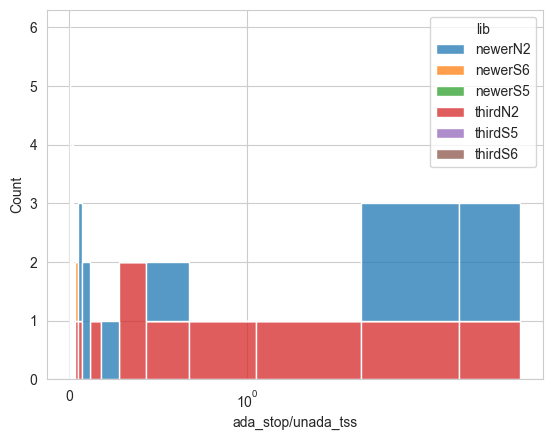

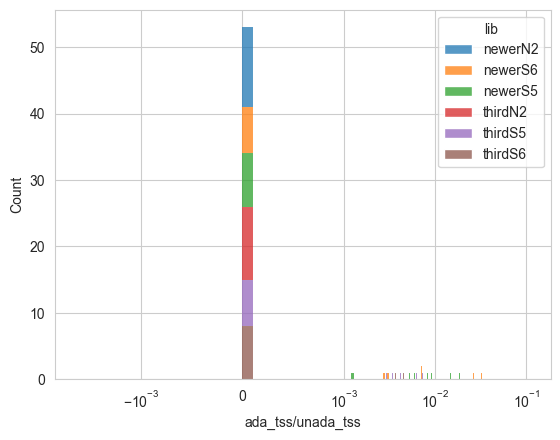

In [12]:
round_inf_to = 4
plotting_summary_df['ada_tss/unada_tss'] = plotting_summary_df['ada_tss/unada_tss'].replace({np.inf: round_inf_to, -np.inf: -round_inf_to})
plotting_summary_df['ada_stop/unada_tss'] = plotting_summary_df['ada_stop/unada_tss'].replace({np.inf: round_inf_to, -np.inf: -round_inf_to})

sea.histplot(data=plotting_summary_df.query("nmd_target_type == 'NMD_Targets'"),
             x='ada_stop/unada_tss',
             hue='lib',
             # element='step',
             bins=20,
             multiple='stack',
             fill=True,
             # discrete=True,
             log_scale=(True, False),
             )
plt.xscale('symlog')
plt.show()
sea.histplot(data=plotting_summary_df.query("nmd_target_type == 'NMD_Targets'"),
             x='ada_tss/unada_tss',
             hue='lib',
             # element='step',
             binwidth=0.0001,
             multiple='stack',
             fill=True,
             # discrete=True,
             # log_scale=(True, False),
             )
plt.xscale('symlog', linthresh=0.001)
plt.show()

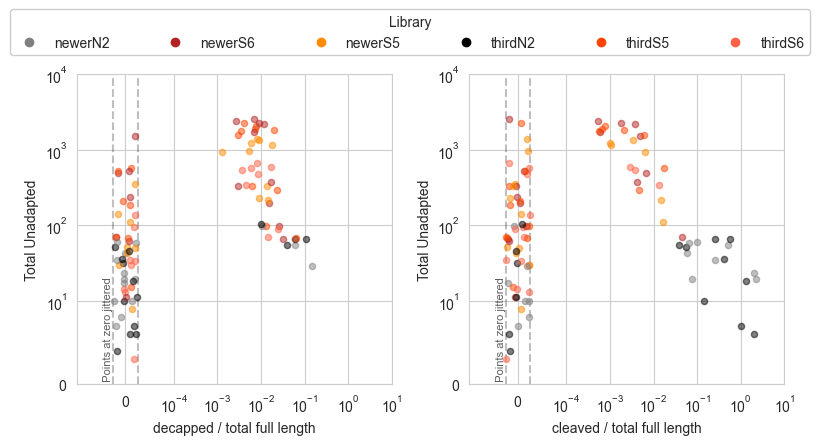

In [13]:
import seaborn.objects as so
import matplotlib.lines as mlines

linthresh = 0.0001
jitter_denominator = 4

# xcols = ['ada_tss/unada_tss', 'ada_stop/unada_tss']
xcols = ['ada_tss/total_tss', 'ada_stop/total_tss']
ycol = 'total_unadapted'

# lib_colors = {
#     'newerN2': 'red',
#     'newerS6': 'grey',
#     'newerS5': 'black',
#     'thirdN2': 'orange',
#     'thirdS6': 'grey',
#     'thirdS5': 'black',
# }
lib_colors = {
    'newerN2': 'grey',
    'newerS6': 'firebrick',
    'newerS5': 'darkorange',
    'thirdN2': 'black',
    'thirdS6': 'tomato',
    'thirdS5': 'orangered',
}

# fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# ((ax1, ax2), (ax3, ax4)) = axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes

nmd_types_to_plot = [
    'NMD_Targets',
    # 'NMD_NonTargets',
]
plot_df = plotting_summary_df.query("nmd_target_type in @nmd_types_to_plot").copy()

plot_df['total_tss'] = plot_df['adapted_near_tss'] + plot_df['unadapted_near_tss']
plot_df['total_stop'] = plot_df['adapted_near_stop'] + plot_df['unadapted_near_tss']

plot_df['ada_tss/total_tss'] = plot_df['adapted_near_tss'] / plot_df['total_tss']
plot_df['ada_stop/total_tss'] = plot_df['adapted_near_stop'] / plot_df['total_tss']

plot_df['lib_colors'] = plot_df.lib.map(lib_colors)
plot_df[xcols[0]] = plot_df[xcols[0]].transform(lambda x: np.random.uniform(
    -linthresh/jitter_denominator,
    linthresh/jitter_denominator,
) if x == 0 else x)
plot_df[xcols[1]] = plot_df[xcols[1]].transform(lambda x: np.random.uniform(
    -linthresh/jitter_denominator,
    linthresh/jitter_denominator,
) if x == 0 else x)

for gene in plot_df.gene_name.unique():
    sub_gene_plot_df = plot_df.query("gene_name == @gene")
    # sub_gene_plot_df.plot(x='ada_tss/unada_tss',
    #                       y='total_unadapted',
    #                       kind='line',
    #                       linestyle=':',
    #                       ax=ax1,
    #                       c='black',
    #                       alpha=0.25)
    # sub_gene_plot_df.plot(x='ada_stop/unada_tss',
    #                       y='total_unadapted',
    #                       kind='line',
    #                       linestyle=':',
    #                       ax=ax2,
    #                       c='black',
    #                       alpha=0.25)
    for lib in sub_gene_plot_df.lib.unique():
        sub_lib_plot_df = sub_gene_plot_df.query("lib == @lib")
        marker_types = ['o', '+']
        for i, nmd_target_type in enumerate(sub_lib_plot_df.nmd_target_type.unique()):
            sub_lib_type_plot_df = sub_gene_plot_df.query("lib == @lib & nmd_target_type == @nmd_target_type")
            sub_lib_type_plot_df.plot(x=xcols[0],
                                 y=ycol,
                                 kind='scatter',
                                 marker=marker_types[i],
                                 ax=ax1,
                                 c=sub_lib_type_plot_df['lib_colors'],
                                 alpha=0.5,
                                 zorder=100)
            sub_lib_type_plot_df.plot(x=xcols[1],
                                 y=ycol,
                                 kind='scatter',
                                 marker=marker_types[i],
                                 ax=ax2,
                                 c=sub_lib_type_plot_df['lib_colors'],
                                 alpha=0.5,
                                 zorder=100)
for ax in axes.flat:
    ax.set_xscale('symlog', linthresh=linthresh)
    ax.set_xlim(-linthresh, 10)
    ax.set_yscale('symlog', linthresh=10)
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    ax.axvline(-linthresh/jitter_denominator,
               color='k', linestyle='--',
               alpha=0.25)
    ax.axvline(linthresh/jitter_denominator,
               color='k', linestyle='--',
               alpha=0.25)
    ax.annotate(' Points at zero jittered',
                xy=(-linthresh/jitter_denominator, 0),
                xytext=(-linthresh/jitter_denominator, 0),
                rotation=90,
                alpha=0.75,
                fontsize=8,
                horizontalalignment='right',
                verticalalignment='bottom',
                )

ax1.set_xlabel("decapped / total full length")
ax1.set_ylabel("Total Unadapted")
ax2.set_xlabel("cleaved / total full length")
ax2.set_ylabel("Total Unadapted")

ax1.set_ylim(0, 1e4)
ax2.set_ylim(0, 1e4)

legend_items = [mlines.Line2D([],
                              [],
                              color=lib_colors[lib],
                              marker='o',
                              linestyle='',
                              label=lib) for lib in plot_df.lib.unique()]
if len(plot_df.nmd_target_type.unique()) > 1:
    legend_items.extend([mlines.Line2D([],
                                       [],
                                       color='black',
                                       marker=marker,
                                       linestyle='',
                                       label=nmd_target_type) for nmd_target_type, marker in zip(plot_df.nmd_target_type.unique(), marker_types)])
    fig.legend(handles=legend_items, title='Library and NMD Type',
               loc='upper center',
               bbox_to_anchor=(0.0, 1.06, 1.0, 0.102),
               ncols=4,
               mode='expand',
               borderaxespad=0.0,
               facecolor='w',
               framealpha=1,
               )
else:
    fig.legend(handles=legend_items, title='Library',
               loc='upper center',
               bbox_to_anchor=(0.0, 1.00, 1.0, 0.102),
               ncols=6,
               mode='expand',
               borderaxespad=0.0,
               facecolor='w',
               framealpha=1,
               )

plt.tight_layout()
plt.draw()
save_dir = current_dir / 'plots' / 'decappingAndCleavage'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / f"SummaryPlot{len(plot_df.nmd_target_type.unique())}.png",
            dpi=300, bbox_inches='tight')
plt.savefig(save_dir / f"SummaryPlot{len(plot_df.nmd_target_type.unique())}.svg",
            bbox_inches='tight')
plt.show()

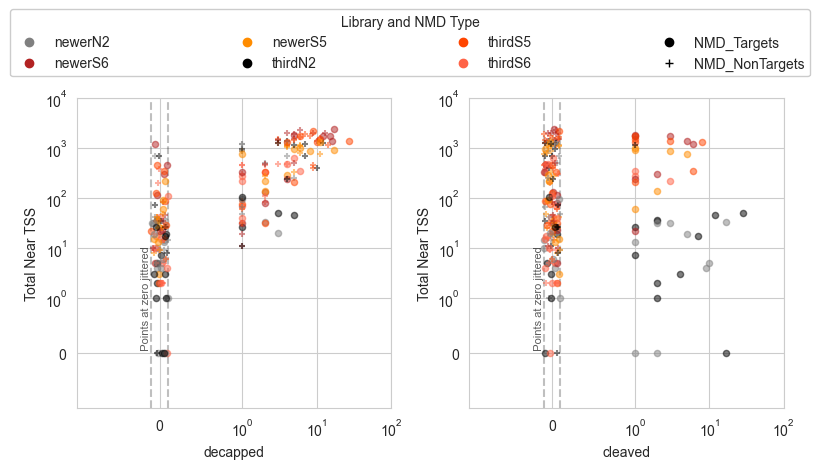

In [14]:
import seaborn.objects as so
import matplotlib.lines as mlines

linthresh = 1
jitter_denominator = 10

# xcols = ['ada_tss/unada_tss', 'ada_stop/unada_tss']
xcols = ['adapted_near_tss', 'adapted_near_stop']
ycol = 'total_tss'

lib_colors = {
    'newerN2': 'grey',
    'newerS6': 'firebrick',
    'newerS5': 'darkorange',
    'thirdN2': 'black',
    'thirdS6': 'tomato',
    'thirdS5': 'orangered',
}

# fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# ((ax1, ax2), (ax3, ax4)) = axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes

nmd_types_to_plot = [
    'NMD_Targets',
    'NMD_NonTargets',
]
plot_df = plotting_summary_df.query("nmd_target_type in @nmd_types_to_plot").copy()

plot_df['total_tss'] = plot_df['adapted_near_tss'] + plot_df['unadapted_near_tss']
plot_df['total_stop'] = plot_df['adapted_near_stop'] + plot_df['unadapted_near_tss']

plot_df['ada_tss/total_tss'] = plot_df['adapted_near_tss'] / plot_df['total_tss']
plot_df['ada_stop/total_tss'] = plot_df['adapted_near_stop'] / plot_df['total_tss']

plot_df['lib_colors'] = plot_df.lib.map(lib_colors)
plot_df[xcols[0]] = plot_df[xcols[0]].transform(lambda x: np.random.uniform(
    -linthresh/jitter_denominator,
    linthresh/jitter_denominator,
) if x == 0 else x)
plot_df[xcols[1]] = plot_df[xcols[1]].transform(lambda x: np.random.uniform(
    -linthresh/jitter_denominator,
    linthresh/jitter_denominator,
) if x == 0 else x)

for gene in plot_df.gene_name.unique():
    sub_gene_plot_df = plot_df.query("gene_name == @gene")
    for lib in sub_gene_plot_df.lib.unique():
        sub_lib_plot_df = sub_gene_plot_df.query("lib == @lib")
        marker_types = ['o', '+']
        for i, nmd_target_type in enumerate(sub_lib_plot_df.nmd_target_type.unique()):
            sub_lib_type_plot_df = sub_gene_plot_df.query("lib == @lib & nmd_target_type == @nmd_target_type")
            sub_lib_type_plot_df.plot(x=xcols[0],
                                 y=ycol,
                                 kind='scatter',
                                 marker=marker_types[i],
                                 ax=ax1,
                                 c=sub_lib_type_plot_df['lib_colors'],
                                 alpha=0.5,
                                 zorder=100)
            sub_lib_type_plot_df.plot(x=xcols[1],
                                 y=ycol,
                                 kind='scatter',
                                 marker=marker_types[i],
                                 ax=ax2,
                                 c=sub_lib_type_plot_df['lib_colors'],
                                 alpha=0.5,
                                 zorder=100)
for ax in axes.flat:
    ax.set_xscale('symlog', linthresh=linthresh)
    ax.set_xlim(-linthresh, 1e2)
    ax.set_yscale('symlog', linthresh=1)
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    ax.axvline(-linthresh/jitter_denominator,
               color='k', linestyle='--',
               alpha=0.25)
    ax.axvline(linthresh/jitter_denominator,
               color='k', linestyle='--',
               alpha=0.25)
    ax.annotate(' Points at zero jittered',
                xy=(-linthresh/jitter_denominator, 0),
                xytext=(-linthresh/jitter_denominator, 0),
                rotation=90,
                alpha=0.75,
                fontsize=8,
                horizontalalignment='right',
                verticalalignment='bottom',
                )

ax1.set_xlabel("decapped")
ax1.set_ylabel("Total Near TSS")
ax2.set_xlabel("cleaved")
ax2.set_ylabel("Total Near TSS")

ax1.set_ylim(-1e0, 1e4)
ax2.set_ylim(-1e0, 1e4)

legend_items = [mlines.Line2D([],
                              [],
                              color=lib_colors[lib],
                              marker='o',
                              linestyle='',
                              label=lib) for lib in plot_df.lib.unique()]
if len(plot_df.nmd_target_type.unique()) > 1:
    legend_items.extend([mlines.Line2D([],
                                       [],
                                       color='black',
                                       marker=marker,
                                       linestyle='',
                                       label=nmd_target_type) for nmd_target_type, marker in zip(plot_df.nmd_target_type.unique(), marker_types)])
    fig.legend(handles=legend_items, title='Library and NMD Type',
               loc='upper center',
               bbox_to_anchor=(0.0, 1.06, 1.0, 0.102),
               ncols=4,
               mode='expand',
               borderaxespad=0.0,
               facecolor='w',
               framealpha=1,
               )
else:
    fig.legend(handles=legend_items, title='Library',
               loc='upper center',
               bbox_to_anchor=(0.0, 1.00, 1.0, 0.102),
               ncols=6,
               mode='expand',
               borderaxespad=0.0,
               facecolor='w',
               framealpha=1,
               )

plt.tight_layout()
plt.draw()
save_dir = current_dir / 'plots' / 'decappingAndCleavage'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / f"SummaryPlot{len(plot_df.nmd_target_type.unique())}.png",
            dpi=300, bbox_inches='tight')
plt.savefig(save_dir / f"SummaryPlot{len(plot_df.nmd_target_type.unique())}.svg",
            bbox_inches='tight')
plt.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

xcols = ['adapted_near_tss', 'adapted_near_stop']
ycol = 'total_tss'

lib_colors = {
    'newerN2': 'grey',
    'newerS6': 'firebrick',
    'newerS5': 'darkorange',
    'thirdN2': 'black',
    'thirdS6': 'tomato',
    'thirdS5': 'orangered',
}

nmd_types_to_plot = [
    'NMD_Targets',
    'NMD_NonTargets',
]
plot_df = plotting_summary_df.query("nmd_target_type in @nmd_types_to_plot").copy()

plot_df['total_tss'] = plot_df['adapted_near_tss'] + plot_df['unadapted_near_tss']
plot_df['total_stop'] = plot_df['adapted_near_stop'] + plot_df['unadapted_near_stop']

plot_df['ada_tss/total_tss'] = plot_df['adapted_near_tss'] / plot_df['total_tss']
plot_df['ada_stop/total_tss'] = plot_df['adapted_near_stop'] / plot_df['total_tss']

plot_df['lib_colors'] = plot_df.lib.map(lib_colors)

figures = []
# for xcol in xcols:
#     figures.append(px.scatter(plot_df,
#                               x=xcol,
#                               y=ycol,
#                               color='lib',
#                               symbol='nmd_target_type',
#                               color_discrete_map=lib_colors,
#                               symbol_sequence=['circle', 'cross'],
#                               log_x=True,
#                               log_y=True,
#                               title=f"{xcol} vs {ycol}",
#                               hover_name='gene_name',
#                               hover_data=[
#                                   'lib',
#                                   'nmd_target_type',
#                                   'total_unadapted',
#                                   'total_adapted',
#                                   'total_tss',
#                                   'total_stop',
#                                           ],
#                               
#                               )
#                      )
for i, xcol in enumerate(xcols):
    for gene_name in plot_df['gene_name'].unique():
        gene_df = plot_df[plot_df['gene_name'] == gene_name]
        figures.append(go.Scatter(
            x=gene_df[xcol],
            y=gene_df[ycol],
            mode='markers',
            marker=dict(
                color=gene_df['lib_colors'],
                symbol=gene_df['nmd_target_type'].map({'NMD_Targets': 'circle', 'NMD_NonTargets': 'cross'}),
                size=10
            ),
            name=gene_name,
            legendgroup=gene_name,
            showlegend=True if i == 0 else False,
        ))
fig = make_subplots(rows=1, cols=(len(xcols)))
for i, figure in enumerate(figures):
    fig.add_trace(figure, row=1, col=(i % len(xcols))+1)

# We need to add axis labels:
fig.update_xaxes(title_text="Decapped", row=1, col=1)
fig.update_xaxes(title_text="Cleaved", row=1, col=2)
fig.update_yaxes(title_text="Total Near TSS", row=1, col=1)
fig.update_yaxes(title_text="Total Near TSS", row=1, col=2)


fig.show(renderer='firefox')

In [17]:
plotting_summary_df

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted,nmd_active,ada_tss/unada_tss,ada_stop/unada_tss
0,aly-3,NMD_Targets,oldN2,0,0,4,3,2,14,True,0.0,0.000000
1,aly-3,NMD_Targets,newerN2,2,0,5,0,0,2,True,NaN,inf
2,aly-3,NMD_Targets,newerS6,1,0,2,7,22,69,False,0.0,0.045455
3,aly-3,NMD_Targets,newerS5,1,0,2,2,13,30,False,0.0,0.076923
4,aly-3,NMD_Targets,thirdN2,2,0,3,0,1,6,True,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
732,rpl-3,All_NMD_Types,thirdS6,0,0,11,18,242,1379,False,0.0,0.000000
733,rpl-3,All_NMD_Types,temp25cN2,0,0,20,0,367,1270,True,0.0,0.000000
734,rpl-3,All_NMD_Types,temp25cS5,1,0,5,24,1504,3007,False,0.0,0.000665
735,rpl-3,All_NMD_Types,temp25cS6,0,0,3,19,1262,3004,False,0.0,0.000000


# Work on 7/8/2024

Trying to get a more simple summary metric working. Going to be more aggressive with throwing out low depth libs.

The general idea is that the increase in reads near the TSS when we break NMD with smg-5 or smg-6 is due to the vast increase of the precursor NMD species. This would be expected if NMD targets were undergoing typical end of life cycle deadenylation and decapping.

If the decapping was somehow an artifact of the NMD knockouts, we'd expect the ratio between reads and TSS reads to differ between NMD targets and non-NMD targets.

An issue here, is that our ability to capture adapted near-TSS species is entirely reliant the knockdown of xrn-1 and the adapter ligation reaction efficacy.

One idea to avoid these sources of noise could be only looking within a library, comparing the ratio of decapped + adapted species on the NMD targets and the non-targets... ? Let's try:

In [25]:
plot_libs = libs_to_run

window_size_for_search = 100

target_nmd_types = ('nmd_target', 'ambiguous', 'non_nmd_target')
subset_nmd_types_list = [target_nmd_types[0], target_nmd_types[1], target_nmd_types[2], target_nmd_types[:2], target_nmd_types[:]]
subset_nmd_types_names = ['NMD_Targets', 'Ambiguous_Reads', 'NMD_NonTargets', 'NMD_TargetsAndAmbiguous', 'All_Types']

plot_lib_objs_dict = {lib: obj_dict[lib] for lib in plot_libs}
overall_summaries_nested_dict = {}
for gene in nmd_genes[::-1]:
    # if gene != "rpl-7A":
    #     continue
    print(f"{gene:#^50}")
    gene_summary_dicts = {}
    
    for subset_nmd_types, subset_nmd_types_name in zip(subset_nmd_types_list, subset_nmd_types_names):
        try:
            lib_df_dict_for_gene = {lib: lib_obj.nmd_targets_df.query('gene_name == @gene & nmd_assignment in @subset_nmd_types')
                                    for lib, lib_obj in plot_lib_objs_dict.items()}
            # summary_dict = plot_gene_data3(gtf_df, gene, lib_df_dict_for_gene, print_stats=False,
            #                                title_override=f"{gene}\nNMD Target Types: {subset_nmd_types}",
            #                                save_name_override=f"{gene}_{subset_nmd_types_name}",
            #                                current_dir=current_dir,)
            summary_dict = just_extract_gene_data(gtf_df, gene, lib_df_dict_for_gene, print_stats=False, window_size=window_size_for_search)
            gene_summary_dicts[subset_nmd_types_name] = summary_dict
        except Exception as e:
            print(f"Error: {e}")
            print(f"Gene: {gene}")
            print(f"NMD Types: {subset_nmd_types}")
            print(f"Continuing...")
    overall_summaries_nested_dict[gene] = gene_summary_dicts

plotting_list_for_df = []

dict_index = 0
for gene, gene_dict in overall_summaries_nested_dict.items():
    for nmd_target_type, target_type_dict in gene_dict.items():
        print(f"{gene} ({nmd_target_type}):")
        for lib, lib_dict in target_type_dict.items():
            print(f"\t{lib}:")
            print(f"\t\tAdapted Near Stop:   {lib_dict['Adapted Near Stop']}")
            print(f"\t\tAdapted Near TSS:    {lib_dict['Adapted Near TSS']}")
            print(f"\t\tTotal Adapted:       {lib_dict['Total Adapted']}")
            print(f"\t\tUnadapted Near Stop: {lib_dict['Unadapted Near Stop']}")
            print(f"\t\tUnadapted Near TSS:  {lib_dict['Unadapted Near TSS']}")
            print(f"\t\tTotal Unadapted:     {lib_dict['Total Unadapted']}")
            try:
                print(f"\t\tAda Stop/Unada FL: {lib_dict['Adapted Near Stop']/lib_dict['Unadapted Near TSS']:.2%}")
            except ZeroDivisionError:
                print(f"\t\tAda Stop/Unada FL: -- NO UNADAPTED FL --")
            plotting_list_for_df.append(
                {
                    'gene_name': gene,
                    'nmd_target_type': nmd_target_type,
                    'lib': lib,
                    'adapted_near_stop': lib_dict['Adapted Near Stop'],
                    'adapted_near_tss': lib_dict['Adapted Near TSS'],
                    'total_adapted': lib_dict['Total Adapted'],
                    'unadapted_near_stop': lib_dict['Unadapted Near Stop'],
                    'unadapted_near_tss': lib_dict['Unadapted Near TSS'],
                    'total_unadapted': lib_dict['Total Unadapted'],
                }
            )

plotting_summary_df = pd.DataFrame.from_records(plotting_list_for_df)
plotting_summary_df

######################aly-3#######################
######################ubl-1#######################
######################rsp-5#######################
######################rpl-12######################
#####################K08D12.3#####################
######################rpl-1#######################
######################rpl-7A######################
#####################R06C1.4######################
#####################ZK228.4######################
Error: not enough values to unpack (expected 2, got 0)
Gene: ZK228.4
NMD Types: non_nmd_target
Continuing...
#####################C53H9.2######################
######################pqn-70######################
######################rps-22######################
######################hel-1#######################
######################rsp-6#######################
######################rpl-30######################
######################rpl-26######################
######################rpl-3#######################
aly-3 (NMD_Targets):
	ol

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted
0,aly-3,NMD_Targets,oldN2,0,0,4,3,2,14
1,aly-3,NMD_Targets,newerN2,2,0,5,0,0,2
2,aly-3,NMD_Targets,newerS6,1,0,2,7,22,69
3,aly-3,NMD_Targets,newerS5,1,0,2,2,13,30
4,aly-3,NMD_Targets,thirdN2,2,0,3,0,1,6
...,...,...,...,...,...,...,...,...,...
919,rpl-3,All_Types,thirdS6,0,0,11,18,242,1379
920,rpl-3,All_Types,temp25cN2,0,0,20,0,367,1270
921,rpl-3,All_Types,temp25cS5,1,0,5,24,1504,3007
922,rpl-3,All_Types,temp25cS6,0,0,3,19,1262,3004


In [26]:
summary_df = plotting_summary_df.copy()

lib_strain_dict = {'N2': 'wildtype',
                   'S5': 'smg-5',
                   'S6': 'smg-6',
                   'S7': 'smg-7'}

summary_df['strain'] = summary_df.lib.str[-2:].map(lib_strain_dict)

summary_df['total_near_tss'] = summary_df['adapted_near_tss'] + summary_df['unadapted_near_tss']
summary_df['total_near_stop'] = summary_df['adapted_near_stop'] + summary_df['unadapted_near_stop']
summary_df['total_reads'] = summary_df['total_adapted'] + summary_df['total_unadapted']

summary_df['frac_near_tss'] = summary_df['total_near_tss'] / summary_df['total_reads']
summary_df['frac_near_stop'] = summary_df['total_near_stop'] / summary_df['total_reads']

summary_df

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted,strain,total_near_tss,total_near_stop,total_reads,frac_near_tss,frac_near_stop
0,aly-3,NMD_Targets,oldN2,0,0,4,3,2,14,wildtype,2,3,18,0.111111,0.166667
1,aly-3,NMD_Targets,newerN2,2,0,5,0,0,2,wildtype,0,2,7,0.000000,0.285714
2,aly-3,NMD_Targets,newerS6,1,0,2,7,22,69,smg-6,22,8,71,0.309859,0.112676
3,aly-3,NMD_Targets,newerS5,1,0,2,2,13,30,smg-5,13,3,32,0.406250,0.093750
4,aly-3,NMD_Targets,thirdN2,2,0,3,0,1,6,wildtype,1,2,9,0.111111,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,rpl-3,All_Types,thirdS6,0,0,11,18,242,1379,smg-6,242,18,1390,0.174101,0.012950
920,rpl-3,All_Types,temp25cN2,0,0,20,0,367,1270,wildtype,367,0,1290,0.284496,0.000000
921,rpl-3,All_Types,temp25cS5,1,0,5,24,1504,3007,smg-5,1504,25,3012,0.499336,0.008300
922,rpl-3,All_Types,temp25cS6,0,0,3,19,1262,3004,smg-6,1262,19,3007,0.419687,0.006319


In [47]:
summary_gb  = summary_df.groupby(['gene_name', 'nmd_target_type', 'strain'])
df = summary_gb['frac_near_tss'].agg(['mean', 'std', 'sem'])

strain_dict = {}
for strain_val in summary_df['strain'].unique():
    strain_dict[strain_val] = df.loc[:, :, strain_val].rename(columns={'mean': f'{strain_val}_mean', 'std': f'{strain_val}_std', 'sem': f'{strain_val}_sem'})
remerge_df = pd.concat(strain_dict.values(), axis=1)

for strain_val in summary_df['strain'].unique():
    if strain_val == 'wildtype':
        continue
    remerge_df[f'{strain_val}/wildtype'] = remerge_df[f'{strain_val}_mean'] / remerge_df['wildtype_mean']
remerge_df[[col for col in remerge_df.columns if 'mean' in col]]  # This is very close, but now I am visually comparing each mean in NMD targets to the non-NMD targets. I want to do this via and actual comparison (maybe plot fractions or do a paired t-test between

wildtype_mean  smg-6_mean  smg-5_mean  smg-7_mean
gene_name nmd_target_type                                                           
C53H9.2   All_Types                     0.096707    0.127863    0.177737    0.016667
          Ambiguous_Reads               0.000000    0.000000    0.000000    0.000000
          NMD_NonTargets                0.794484    0.638889    0.591667    0.000000
          NMD_Targets                   0.702778    0.577242    0.665275    1.000000
          NMD_TargetsAndAmbiguous       0.030830    0.114005    0.167194    0.016949
...                                          ...         ...         ...         ...
ubl-1     All_Types                     0.692002    0.698605    0.803280    0.384000
          Ambiguous_Reads               0.000000    0.000000    0.000000    0.000000
          NMD_NonTargets                0.918379    0.888120    0.920577    0.876209
          NMD_Targets                   0.935480    0.935566    0.953122    0.862069
          NMD_TargetsAndAmbiguous       0.147588    0.594585    0.726302    0.087413

[84 rows x 4 columns]

In [62]:
plot_df = remerge_df[[col for col in remerge_df.columns if 'mean' in col and 'smg-7' not in col]].loc[:, ['NMD_Targets', 'NMD_NonTargets'], :].reset_index()

fig = px.bar(plot_df,
             x='gene_name',
             y=[col for col in plot_df.columns if 'mean' in col and 'smg-7' not in col],
             color='nmd_target_type',
             barmode='group',
             )
fig.show(renderer='firefox')
plot_df

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,gene_name,nmd_target_type,wildtype_mean,smg-6_mean,smg-5_mean
0,C53H9.2,NMD_Targets,0.702778,0.577242,0.665275
1,K08D12.3,NMD_Targets,0.531640,0.962019,0.971487
2,R06C1.4,NMD_Targets,0.081179,0.526224,0.624047
3,ZK228.4,NMD_Targets,1.000000,1.000000,1.000000
4,aly-3,NMD_Targets,0.055556,0.328539,0.451497
5,hel-1,NMD_Targets,0.152778,0.198925,0.335589
6,pqn-70,NMD_Targets,0.715909,0.632323,0.706899
7,rpl-1,NMD_Targets,0.721679,0.854428,0.871381
8,rpl-12,NMD_Targets,0.490618,0.646711,0.746542
9,rpl-26,NMD_Targets,0.579645,0.694745,0.814037


In [70]:
wider_plot_dict = {}
for target_type in plot_df['nmd_target_type'].unique():
    target_type_df = plot_df.query("nmd_target_type == @target_type").drop(columns='nmd_target_type')
    wider_plot_dict[target_type] = target_type_df.rename(columns={col: f"{target_type}_{col}" for col in target_type_df.columns if 'mean' in col}).set_index('gene_name')
wider_plot_df = pd.concat(wider_plot_dict.values(), axis=1)
wider_plot_df

,NMD_Targets_wildtype_mean,NMD_Targets_smg-6_mean,NMD_Targets_smg-5_mean,NMD_NonTargets_wildtype_mean,NMD_NonTargets_smg-6_mean,NMD_NonTargets_smg-5_mean
gene_name,,,,,,
C53H9.2,0.702778,0.577242,0.665275,0.794484,0.638889,0.591667
K08D12.3,0.531640,0.962019,0.971487,0.993198,0.987955,0.996431
R06C1.4,0.081179,0.526224,0.624047,0.806193,0.815305,0.828416
ZK228.4,1.000000,1.000000,1.000000,NaN,NaN,NaN
aly-3,0.055556,0.328539,0.451497,0.653413,0.559092,0.628756
hel-1,0.152778,0.198925,0.335589,0.453922,0.404081,0.477567
pqn-70,0.715909,0.632323,0.706899,0.739556,0.541667,0.618172
rpl-1,0.721679,0.854428,0.871381,0.934727,0.915987,0.943599
rpl-12,0.490618,0.646711,0.746542,0.847049,0.779108,0.833564


In [72]:
for lib_mean in ['wildtype_mean', 'smg-5_mean', 'smg-6_mean']:
    wider_plot_df[f"{lib_mean}_diff"] = wider_plot_df[f'NMD_Targets_{lib_mean}'] - wider_plot_df[f'NMD_NonTargets_{lib_mean}']
    wider_plot_df[f"{lib_mean}_diff_frac"] = wider_plot_df[f'NMD_Targets_{lib_mean}'] / wider_plot_df[f'NMD_NonTargets_{lib_mean}']
wider_plot_df[[col for col in wider_plot_df.columns if 'diff' in col]]

# THE PROBLEM: I merged on lib types (N2, S5, S6) before I made the actual comparisons between NMD targets and non-NMD targets. I need to do this first, then merge. This will allow me to target the issue I noted above regarding variable depth, ligation, and xrn-1 knockdown!!

,wildtype_mean_diff,wildtype_mean_diff_frac,smg-5_mean_diff,smg-5_mean_diff_frac,smg-6_mean_diff,smg-6_mean_diff_frac
gene_name,,,,,,
C53H9.2,-0.091707,0.884571,0.073608,1.124408,-0.061647,0.903509
K08D12.3,-0.461558,0.535281,-0.024944,0.974966,-0.025936,0.973748
R06C1.4,-0.725013,0.100695,-0.204369,0.753302,-0.289081,0.645432
ZK228.4,NaN,NaN,NaN,NaN,NaN,NaN
aly-3,-0.597858,0.085024,-0.177260,0.718079,-0.230553,0.587629
hel-1,-0.301145,0.336573,-0.141978,0.702706,-0.205157,0.492289
pqn-70,-0.023647,0.968025,0.088727,1.143531,0.090657,1.167366
rpl-1,-0.213048,0.772075,-0.072218,0.923465,-0.061559,0.932795
rpl-12,-0.356431,0.579209,-0.087022,0.895603,-0.132397,0.830066


# THE PROBLEM:
I merged on lib types (N2, S5, S6) before I made the actual comparisons between NMD targets and non-NMD targets. I need to do this first, then merge. This will allow me to target the issue I noted above regarding variable depth, ligation, and xrn-1 knockdown!!

1. We want to compare the TSS ratio for NMD vs non_NMD targets in each library
2. We can take a mean of those ratios for each strain (ie. wt or smg-5)
3. Finally we can compare the mean ratios between strains, WT should look similar to smg-5 and smg-6 (if nothing is changing on the decapping front)

In [222]:
# Before anything let's copy down code so we can regenerate the input df
summary_df = plotting_summary_df.copy()

lib_strain_dict = {'N2': 'wildtype',
                   'S5': 'smg-5',
                   'S6': 'smg-6',
                   'S7': 'smg-7'}

summary_df['strain'] = summary_df.lib.str[-2:].map(lib_strain_dict)

summary_df['total_near_tss'] = summary_df['adapted_near_tss'] + summary_df['unadapted_near_tss']
summary_df['total_near_stop'] = summary_df['adapted_near_stop'] + summary_df['unadapted_near_stop']
summary_df['total_reads'] = summary_df['total_adapted'] + summary_df['total_unadapted']

# There are a few different ways to do this!
summary_df['frac_near_tss'] = summary_df['total_near_tss'] / summary_df['total_reads']

summary_df['frac_near_tss'] = summary_df['adapted_near_tss'] / summary_df['total_reads']

summary_df

,gene_name,nmd_target_type,lib,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted,strain,total_near_tss,total_near_stop,total_reads,frac_near_tss
0,aly-3,NMD_Targets,oldN2,0,0,4,3,2,14,wildtype,2,3,18,0.0
1,aly-3,NMD_Targets,newerN2,2,0,5,0,0,2,wildtype,0,2,7,0.0
2,aly-3,NMD_Targets,newerS6,1,0,2,7,22,69,smg-6,22,8,71,0.0
3,aly-3,NMD_Targets,newerS5,1,0,2,2,13,30,smg-5,13,3,32,0.0
4,aly-3,NMD_Targets,thirdN2,2,0,3,0,1,6,wildtype,1,2,9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,rpl-3,All_Types,thirdS6,0,0,11,18,242,1379,smg-6,242,18,1390,0.0
920,rpl-3,All_Types,temp25cN2,0,0,20,0,367,1270,wildtype,367,0,1290,0.0
921,rpl-3,All_Types,temp25cS5,1,0,5,24,1504,3007,smg-5,1504,25,3012,0.0
922,rpl-3,All_Types,temp25cS6,0,0,3,19,1262,3004,smg-6,1262,19,3007,0.0


In [251]:
# First we want to compare the TSS ratio for NMD vs non_NMD targets in each library
in_df = summary_df.copy()
set_dict = {'old': 1, 'newer': 2, 'third': 3, 'temp25c': 4}

in_df['rep'] = in_df.lib.str[:-2].map(set_dict)
in_df = in_df.set_index(['gene_name', 'nmd_target_type', 'strain', 'rep','lib'])[['frac_near_tss', 'total_reads']].sort_index()
inter_wide_df = in_df.loc[:, ['NMD_Targets', 'NMD_NonTargets'], :].unstack('nmd_target_type')
inter_wide_df

frac_near_tss                total_reads               
nmd_target_type                    NMD_Targets NMD_NonTargets NMD_Targets NMD_NonTargets
gene_name strain   rep lib                                                              
C53H9.2   smg-5    2   newerS5        0.000000       0.000000       140.0           12.0
                   3   thirdS5        0.000000       0.000000       213.0           15.0
                   4   temp25cS5      0.000000       0.000000       115.0           16.0
          smg-6    2   newerS6        0.009901       0.000000       202.0           20.0
                   3   thirdS6        0.000000       0.000000        35.0            3.0
...                                        ...            ...         ...            ...
ubl-1     smg-7    4   temp25cS7      0.000000       0.001934        87.0          517.0
          wildtype 1   oldN2          0.000000       0.007491        52.0         1602.0
                   2   newerN2        0.010000       0.000770       100.0         1298.0
                   3   thirdN2        0.009434       0.003981       106.0         1256.0
                   4   temp25cN2      0.000000       0.004573        49.0          656.0

[187 rows x 4 columns]

In [ ]:
# Second we can take a mean of those ratios for each strain (ie. wt or smg-5)
# First lets drop anything that doesn't have at least X reads for each:
min_reads = 50
semi_wide_df = inter_wide_df.copy()
semi_wide_df = semi_wide_df[semi_wide_df['total_reads'] >= min_reads].dropna(axis=0)
# So we want to divide the NMD_Targets by the NMD_NonTargets for each row of semi_wide_df
semi_wide_df['near_tss(nmd / non_nmd)'] = semi_wide_df['frac_near_tss']['NMD_Targets'] / semi_wide_df['frac_near_tss']['NMD_NonTargets']
semi_wide_df['total_total_reads'] = semi_wide_df['total_reads']['NMD_Targets'] + semi_wide_df['total_reads']['NMD_NonTargets']

In [320]:
comp_box_df = semi_wide_df.copy().reset_index()
comp_box_df = comp_box_df[comp_box_df['near_tss(nmd / non_nmd)'] > 0]
comp_box_df['log2_near_tss(nmd / non_nmd)'] = np.log2(comp_box_df['near_tss(nmd / non_nmd)'])
comp_box_df.columns = ["_".join(a).strip('_') for a in comp_box_df.columns.to_flat_index()]
fig = px.box(comp_box_df,
             x='strain',
             y='near_tss(nmd / non_nmd)',
             log_y=True,
             # color='gene_name',
             points='all',
             hover_name='gene_name',
             hover_data=['rep',
                         'strain',
                         'lib',
                         'near_tss(nmd / non_nmd)',
                         'frac_near_tss_NMD_Targets',
                         'frac_near_tss_NMD_NonTargets',
                         ],
                )
fig.show()
comp_box_df

,gene_name,strain,rep,lib,frac_near_tss_NMD_Targets,frac_near_tss_NMD_NonTargets,total_reads_NMD_Targets,total_reads_NMD_NonTargets,near_tss(nmd / non_nmd),total_total_reads,log2_near_tss(nmd / non_nmd)
0,K08D12.3,smg-5,2,newerS5,0.008772,0.015385,228.0,325.0,0.570175,553.0,-0.810522
1,K08D12.3,smg-5,3,thirdS5,0.006042,0.019272,331.0,467.0,0.313528,798.0,-1.673334
3,K08D12.3,smg-6,2,newerS6,0.002985,0.004141,335.0,483.0,0.720896,818.0,-0.472138
4,K08D12.3,smg-6,3,thirdS6,0.014085,0.024390,71.0,82.0,0.577465,153.0,-0.792195
6,R06C1.4,smg-5,2,newerS5,0.004425,0.003185,226.0,314.0,1.389381,540.0,0.474442
7,R06C1.4,smg-5,3,thirdS5,0.013245,0.014799,302.0,473.0,0.894986,775.0,-0.160063
8,R06C1.4,smg-5,4,temp25cS5,0.018100,0.014151,221.0,212.0,1.279035,433.0,0.355055
9,R06C1.4,smg-6,2,newerS6,0.007812,0.007042,384.0,568.0,1.109375,952.0,0.149747
10,R06C1.4,smg-6,3,thirdS6,0.010989,0.014599,91.0,137.0,0.752747,228.0,-0.409763
11,R06C1.4,smg-6,4,temp25cS6,0.004329,0.005102,231.0,196.0,0.848485,427.0,-0.237039


In [201]:
# Finally we can compare the mean ratios between strains, WT should look similar to smg-5 and smg-6
final_df = semi_wide_df.copy()
final_df.columns = ["_".join(a).strip('_') for a in final_df.columns.to_flat_index()]
final_df = final_df[['frac_near_tss_NMD_Targets', 'frac_near_tss_NMD_NonTargets', 'NMD_Targets_frac', 'total_total_reads']]
final_df.sort_index()

frac_near_tss_NMD_Targets  frac_near_tss_NMD_NonTargets  NMD_Targets_frac  total_total_reads
gene_name strain   rep lib                                                                                                    
K08D12.3  smg-5    2   newerS5                     0.964912                      1.000000          0.964912              553.0
                   3   thirdS5                     0.978852                      0.989293          0.989446              798.0
                   4   temp25cS5                   0.970696                      1.000000          0.970696              621.0
          smg-6    2   newerS6                     0.979104                      0.995859          0.983176              818.0
                   3   thirdS6                     0.929577                      0.975610          0.952817              153.0
...                                                     ...                           ...               ...                ...
ubl-1     smg-6    4   temp25cS6                   0.956790                      0.905455          1.056696             2234.0
          smg-7    4   temp25cS7                   0.862069                      0.876209          0.983862              604.0
          wildtype 1   oldN2                       0.961538                      0.953808          1.008105             1654.0
                   2   newerN2                     0.950000                      0.900616          1.054833             1398.0
                   3   thirdN2                     0.952830                      0.904459          1.053481             1362.0

[92 rows x 4 columns]

In [321]:
plot_df = final_df.reset_index()
window_size_for_search = 100
limits = [-0.1, 1.1] # [-0.0025, 0.03] # [-0.1, 1.1]
read_type = "Any Read" # "Adapted Reads" # Any Read

plot_df['name'] = plot_df['gene_name'] + ' ' + plot_df['strain'] + ' rep' + plot_df['rep'].astype(str)
fig = px.scatter(plot_df,
                 x='frac_near_tss_NMD_Targets',
                 y='frac_near_tss_NMD_NonTargets',
                 color='gene_name',
                 hover_name='name',
                 size='total_total_reads',
                 )
fig.update_layout(shapes = [{'type': 'line', 'line': {'dash': 'dot'}, 'yref': 'y', 'xref': 'x', 'y0': -1, 'y1': 2, 'x0': -1, 'x1': 2}],
                  title=f'Fraction of Total Reads Near TSS<br>(Counting {read_type} within {window_size_for_search}nt)',
                  )
fig.update_xaxes(constrain='domain', range=limits)  
fig.update_yaxes(scaleanchor= 'x', scaleratio= 1, range=limits)
fig.write_html(current_dir / 'plots' / 'decappingAndCleavage' / f"FractionOfTotalReadsNearTSS_{read_type.replace(' ', '')}.html")
fig.write_image(current_dir / 'plots' / 'decappingAndCleavage' / f"FractionOfTotalReadsNearTSS_{read_type.replace(' ', '')}.png")
fig.show()
plot_df

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,gene_name,strain,rep,lib,frac_near_tss_NMD_Targets,frac_near_tss_NMD_NonTargets,NMD_Targets_frac,total_total_reads,name
0,K08D12.3,smg-5,2,newerS5,0.964912,1.000000,0.964912,553.0,K08D12.3 smg-5 rep2
1,K08D12.3,smg-5,3,thirdS5,0.978852,0.989293,0.989446,798.0,K08D12.3 smg-5 rep3
2,K08D12.3,smg-5,4,temp25cS5,0.970696,1.000000,0.970696,621.0,K08D12.3 smg-5 rep4
3,K08D12.3,smg-6,2,newerS6,0.979104,0.995859,0.983176,818.0,K08D12.3 smg-6 rep2
4,K08D12.3,smg-6,3,thirdS6,0.929577,0.975610,0.952817,153.0,K08D12.3 smg-6 rep3
...,...,...,...,...,...,...,...,...,...
87,ubl-1,smg-6,4,temp25cS6,0.956790,0.905455,1.056696,2234.0,ubl-1 smg-6 rep4
88,ubl-1,smg-7,4,temp25cS7,0.862069,0.876209,0.983862,604.0,ubl-1 smg-7 rep4
89,ubl-1,wildtype,1,oldN2,0.961538,0.953808,1.008105,1654.0,ubl-1 wildtype rep1
90,ubl-1,wildtype,2,newerN2,0.950000,0.900616,1.054833,1398.0,ubl-1 wildtype rep2


In [206]:
final_df.unstack("strain").mean()

                              strain  
frac_near_tss_NMD_Targets     smg-5          0.748955
                              smg-6          0.712879
                              smg-7          0.487448
                              wildtype       0.551866
frac_near_tss_NMD_NonTargets  smg-5          0.850334
                              smg-6          0.825602
                              smg-7          0.720703
                              wildtype       0.869742
NMD_Targets_frac              smg-5          0.868995
                              smg-6          0.853009
                              smg-7          0.649352
                              wildtype       0.637929
total_total_reads             smg-5       1800.305556
                              smg-6       1705.058824
                              smg-7        565.400000
                              wildtype    1332.176471
dtype: float64

In [208]:
final_df.unstack("strain").describe()

frac_near_tss_NMD_Targets                                 frac_near_tss_NMD_NonTargets                                 NMD_Targets_frac                                 total_total_reads  \
strain                     smg-5      smg-6     smg-7   wildtype                        smg-5      smg-6     smg-7   wildtype            smg-5      smg-6     smg-7   wildtype             smg-5   
count                  36.000000  34.000000  5.000000  17.000000                    36.000000  34.000000  5.000000  17.000000        36.000000  34.000000  5.000000  17.000000         36.000000   
mean                    0.748955   0.712879  0.487448   0.551866                     0.850334   0.825602  0.720703   0.869742         0.868995   0.853009  0.649352   0.637929       1800.305556   
std                     0.191392   0.209781  0.322709   0.238040                     0.128461   0.147416  0.233196   0.115994         0.130171   0.153948  0.315785   0.259003       1196.146809   
min                     0.300000   0.309859  0.181818   0.117647                     0.452381   0.396226  0.460000   0.631633         0.579714   0.504628  0.241049   0.142108        120.000000   
25%                     0.602015   0.562920  0.183333   0.421687                     0.799352   0.748028  0.506744   0.826355         0.817766   0.719260  0.395257   0.505263        604.000000   
50%                     0.783231   0.741139  0.427966   0.469880                     0.838961   0.823701  0.760563   0.900616         0.888558   0.897149  0.782051   0.571122       1916.000000   
75%                     0.930418   0.902291  0.782051   0.642857                     0.960239   0.966382  0.876209   0.953808         0.982715   0.973888  0.844541   0.835293       2566.750000   
max                     0.985492   0.989623  0.862069   0.961538                     1.000000   1.000000  1.000000   1.000000         1.042932   1.069542  0.983862   1.054833       4144.000000   

                                               
strain        smg-6        smg-7     wildtype  
count     34.000000     5.000000    17.000000  
mean    1705.058824   565.400000  1332.176471  
std     1456.032653   430.482636   383.998736  
min      128.000000   131.000000   295.000000  
25%      513.750000   405.000000  1061.000000  
50%     1299.000000   413.000000  1362.000000  
75%     2414.750000   604.000000  1654.000000  
max     5294.000000  1274.000000  1840.000000

In [212]:
fig = px.box(final_df.reset_index(),
             x='strain',
             y='NMD_Targets_frac',
             # color='gene_name',
             points='all',
             )
fig.show(renderer='firefox')
final_df.reset_index()

,gene_name,strain,rep,lib,frac_near_tss_NMD_Targets,frac_near_tss_NMD_NonTargets,NMD_Targets_frac,total_total_reads
0,K08D12.3,smg-5,2,newerS5,0.964912,1.000000,0.964912,553.0
1,K08D12.3,smg-5,3,thirdS5,0.978852,0.989293,0.989446,798.0
2,K08D12.3,smg-5,4,temp25cS5,0.970696,1.000000,0.970696,621.0
3,K08D12.3,smg-6,2,newerS6,0.979104,0.995859,0.983176,818.0
4,K08D12.3,smg-6,3,thirdS6,0.929577,0.975610,0.952817,153.0
...,...,...,...,...,...,...,...,...
87,ubl-1,smg-6,4,temp25cS6,0.956790,0.905455,1.056696,2234.0
88,ubl-1,smg-7,4,temp25cS7,0.862069,0.876209,0.983862,604.0
89,ubl-1,wildtype,1,oldN2,0.961538,0.953808,1.008105,1654.0
90,ubl-1,wildtype,2,newerN2,0.950000,0.900616,1.054833,1398.0


In [214]:
semi_wide_df

frac_near_tss                total_reads                NMD_Targets_frac total_total_reads
nmd_target_type                    NMD_Targets NMD_NonTargets NMD_Targets NMD_NonTargets                                   
gene_name strain   rep lib                                                                                                 
K08D12.3  smg-5    2   newerS5        0.964912       1.000000       228.0          325.0         0.964912             553.0
                   3   thirdS5        0.978852       0.989293       331.0          467.0         0.989446             798.0
                   4   temp25cS5      0.970696       1.000000       273.0          348.0         0.970696             621.0
          smg-6    2   newerS6        0.979104       0.995859       335.0          483.0         0.983176             818.0
                   3   thirdS6        0.929577       0.975610        71.0           82.0         0.952817             153.0
...                                        ...            ...         ...            ...              ...               ...
ubl-1     smg-6    4   temp25cS6      0.956790       0.905455      1134.0         1100.0         1.056696            2234.0
          smg-7    4   temp25cS7      0.862069       0.876209        87.0          517.0         0.983862             604.0
          wildtype 1   oldN2          0.961538       0.953808        52.0         1602.0         1.008105            1654.0
                   2   newerN2        0.950000       0.900616       100.0         1298.0         1.054833            1398.0
                   3   thirdN2        0.952830       0.904459       106.0         1256.0         1.053481            1362.0

[92 rows x 6 columns]

In [390]:
min_reads = 50

box_df = in_df.loc[:, :, :, :, ['NMD_Targets', 'NMD_NonTargets'], :].reset_index()
box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'] + ' rep' + box_df['rep'].astype(str)
box_df = box_df[box_df['total_reads'] >= min_reads].dropna(axis=0)
box_df = box_df[box_df['frac_near_tss'] > 0]

fig = px.box(box_df,
             x='strain',
             y='frac_near_tss',
             color='nmd_target_type',
             points='all',
             hover_name='name',
             log_y=True,
             )
fig.show(renderer='firefox')
box_df

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,gene_name,strain,rep,lib,nmd_target_type,adapted_near_stop,adapted_near_tss,total_adapted,unadapted_near_stop,unadapted_near_tss,total_unadapted,total_near_tss,total_near_stop,total_reads,frac_near_tss,name
3,C53H9.2,smg-6,2,newerS6,NMD_Targets,0,2,3,0,126,199,128,0,202,0.009901,C53H9.2 smg-6 rep2
11,K08D12.3,smg-5,2,newerS5,NMD_Targets,0,2,2,2,218,226,220,2,228,0.008772,K08D12.3 smg-5 rep2
12,K08D12.3,smg-5,3,thirdS5,NMD_Targets,0,2,2,2,322,329,324,2,331,0.006042,K08D12.3 smg-5 rep3
14,K08D12.3,smg-6,2,newerS6,NMD_Targets,0,1,1,2,327,334,328,2,335,0.002985,K08D12.3 smg-6 rep2
15,K08D12.3,smg-6,3,thirdS6,NMD_Targets,0,1,1,3,65,70,66,3,71,0.014085,K08D12.3 smg-6 rep3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,ubl-1,smg-7,4,temp25cS7,NMD_NonTargets,0,1,1,21,452,516,453,21,517,0.001934,ubl-1 smg-7 rep4
359,ubl-1,wildtype,1,oldN2,NMD_NonTargets,0,12,13,26,1516,1589,1528,26,1602,0.007491,ubl-1 wildtype rep1
360,ubl-1,wildtype,2,newerN2,NMD_NonTargets,0,1,2,46,1168,1296,1169,46,1298,0.000770,ubl-1 wildtype rep2
361,ubl-1,wildtype,3,thirdN2,NMD_NonTargets,1,5,8,41,1131,1248,1136,42,1256,0.003981,ubl-1 wildtype rep3


In [391]:
import scipy.stats as stats
from colorama import Fore, Style

def run_stats_intralib(df_in, compare_col, sig_cutoff=0.05, steps=[100, 10, 1],
                       strains=('wildtype', 'smg-5', 'smg-6'),
                       output_file: Path = None):
    test_results = {}
    output_string = ""
    for strain in strains:
        nmd_df = df_in.query("strain == @strain & nmd_target_type == 'NMD_Targets'")
        non_nmd_df = df_in.query("strain == @strain & nmd_target_type == 'NMD_NonTargets'")
        merge_df = nmd_df.merge(non_nmd_df,
                                on=('gene_name', 'strain', 'rep', 'lib', 'name'),
                                suffixes=('_nmd', '_non_nmd'))
        paired_test = stats.ttest_rel(merge_df[f'{compare_col}_nmd'], merge_df[f'{compare_col}_non_nmd'])
        unpaired_test = stats.ttest_ind(nmd_df[compare_col], non_nmd_df[compare_col])
        test_results[strain] = {'paired': paired_test, 'unpaired': unpaired_test}
    output_string += f"{'Strain':^8} | {'Paired p-val (df)':^15} | {'Unpaired p-val (df)':^15}\n"
    output_string += '-' * 50 + '\n'
    for strain, test_dict in test_results.items():
        paired_str = f" {test_dict['paired'].pvalue:^1.3e}   ({test_dict['paired'].df:>2})"
        unpaired_str = f"   {test_dict['unpaired'].pvalue:^1.3e}   ({int(test_dict['unpaired'].df):>2})"
        if test_dict['paired'].pvalue < sig_cutoff / steps[0]:
            paired_str = Fore.MAGENTA + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[1]:
            paired_str = Fore.RED + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[2]:
            paired_str = Fore.YELLOW + paired_str + Style.RESET_ALL
        if test_dict['unpaired'].pvalue < sig_cutoff / steps[0]:
            unpaired_str = Fore.MAGENTA + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[1]:
            unpaired_str = Fore.RED + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[2]:
            unpaired_str = Fore.YELLOW + unpaired_str + Style.RESET_ALL
        output_string += f"{strain:>8} | {paired_str} | {unpaired_str}\n"
    key_string = (f"Key: "
                  f"{Fore.MAGENTA}p < {sig_cutoff / steps[0]}{Style.RESET_ALL} "
                  f"{Fore.RED}p < {sig_cutoff / steps[1]}{Style.RESET_ALL} "
                  f"{Fore.YELLOW}p < {sig_cutoff / steps[2]}{Style.RESET_ALL}\n")
    print(output_string + key_string)
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    output_string = ansi_escape.sub('', output_string)
    if output_file is not None:
        with open(output_file, 'a') as f:
            f.write(output_string)
    return output_string

def run_stats_interlib(df_in, compare_col, sig_cutoff=0.05, steps=[100, 10, 1],
                       comparisons=(('wildtype', 'smg-5'), ('wildtype', 'smg-6'), ('smg-5', 'smg-6')),
                       nmd_type='NMD_NonTargets',
                       output_file=None):
    # Now let's do a similar comparison but between non-NMD-targets between libs
    test_results = {}
    output_string = ""
    for comp in comparisons:
        nmd_df = df_in.query("strain == @comp[0] & nmd_target_type == @nmd_type")
        non_nmd_df = df_in.query("strain == @comp[1] & nmd_target_type == @nmd_type")
        drop_cols = ['nmd_target_type', 'strain', 'lib', 'name']
        merge_df = nmd_df.drop(columns=drop_cols).merge(non_nmd_df.drop(columns=drop_cols), on=('gene_name', 'rep'), suffixes=('_lib1', '_lib2'))
        paired_test = stats.ttest_rel(merge_df[f'{compare_col}_lib1'], merge_df[f'{compare_col}_lib2'])
        unpaired_test = stats.ttest_ind(nmd_df[compare_col], non_nmd_df[compare_col])
        test_results[comp] = {'paired': paired_test, 'unpaired': unpaired_test}
    
    output_string += f"{'Comp':^14} | {'Paired p-val (df)':^15} | {'Unpaired p-val (df)':^15}\n"
    output_string += '-'*56 + '\n'
    
    for (lib1, lib2), test_dict in test_results.items():
        paired_str = f" {test_dict['paired'].pvalue:^1.3e}   ({test_dict['paired'].df:>2})"
        unpaired_str = f"   {test_dict['unpaired'].pvalue:^1.3e}   ({int(test_dict['unpaired'].df):>2})"
        if lib1 == 'wildtype':
            lib1 = 'wt'
        if test_dict['paired'].pvalue < sig_cutoff / steps[0]:
            paired_str = Fore.MAGENTA + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[1]:
            paired_str = Fore.RED + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[2]:
            paired_str = Fore.YELLOW + paired_str + Style.RESET_ALL
        if test_dict['unpaired'].pvalue < sig_cutoff / steps[0]:
            unpaired_str = Fore.MAGENTA + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[1]:
            unpaired_str = Fore.RED + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[2]:
            unpaired_str = Fore.YELLOW + unpaired_str + Style.RESET_ALL
        output_string += f"{lib1:>5} vs {lib2:<5} | {paired_str} | {unpaired_str}\n"
    key_string = (f"Key: "
                  f"{Fore.MAGENTA}p < {sig_cutoff / steps[0]}{Style.RESET_ALL} "
                  f"{Fore.RED}p < {sig_cutoff / steps[1]}{Style.RESET_ALL} "
                  f"{Fore.YELLOW}p < {sig_cutoff / steps[2]}{Style.RESET_ALL}\n")
    print(output_string + key_string)
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    output_string = ansi_escape.sub('', output_string)
    if output_file is not None:
        with open(output_file, 'a') as f:
            f.write(output_string)
    return output_string

run_stats_intralib(box_df, 'frac_near_tss')
print("\n\n")
run_stats_interlib(box_df, 'frac_near_tss')

 Strain  | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------
wildtype |  1.583e-02   ( 9) |    2.835e-06   (48)
   smg-5 |  4.824e-01   (18) |    4.276e-01   (51)
   smg-6 |  2.358e-01   (21) |    9.175e-01   (50)
Key: p < 0.0005 p < 0.005 p < 0.05




     Comp      | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------------
   wt vs smg-5 |  2.390e-01   (22) |    9.988e-01   (67)
   wt vs smg-6 |  7.098e-01   (22) |    3.117e-01   (64)
smg-5 vs smg-6 |  2.442e-01   (24) |    3.357e-01   (53)
Key: p < 0.0005 p < 0.005 p < 0.05


'     Comp      | Paired p-val (df) | Unpaired p-val (df)\n--------------------------------------------------------\n   wt vs smg-5 |  2.390e-01   (22) |    9.988e-01   (67)\n   wt vs smg-6 |  7.098e-01   (22) |    3.117e-01   (64)\nsmg-5 vs smg-6 |  2.442e-01   (24) |    3.357e-01   (53)\n'

In [326]:
# Maybe the NMD targets have higher adapted_TSS fractions in the WT not because they have high numbers of adapted_TSS reads, but b/c they have lower numbers of the denominator (all reads)
# To remedy this, let's try comparing the adapted_TSS to the unadapted_TSS

# Additionally, it would be nice to do an adapted RPM comparison against Adapt TSS reads. But this needs more reads!!

# I need to circle WAY back to retain both adapt and unadapted TSSes.. UGH LETS DO IT
in_df = summary_df.copy()
set_dict = {'old': 1, 'newer': 2, 'third': 3, 'temp25c': 4}

in_df['rep'] = in_df.lib.str[:-2].map(set_dict)
in_df = in_df.set_index(['gene_name', 'strain', 'rep','lib', 'nmd_target_type']).sort_index()
better_df = in_df.loc[:, :, :, :, ['NMD_Targets', 'NMD_NonTargets'], :].drop(columns=['frac_near_tss'])
better_df

adapted_near_stop  adapted_near_tss  total_adapted  unadapted_near_stop  unadapted_near_tss  total_unadapted  total_near_tss  total_near_stop  \
gene_name strain   rep lib       nmd_target_type                                                                                                                                                  
C53H9.2   smg-5    2   newerS5   NMD_Targets                      0                 0              1                    0                  92              139              92                0   
                   3   thirdS5   NMD_Targets                      0                 0              2                    0                 124              211             124                0   
                   4   temp25cS5 NMD_Targets                      0                 0              0                    0                  87              115              87                0   
          smg-6    2   newerS6   NMD_Targets                      0                 2              3                    0                 126              199             128                0   
                   3   thirdS6   NMD_Targets                      0                 0              1                    0                  15               34              15                0   
...                                                             ...               ...            ...                  ...                 ...              ...             ...              ...   
ubl-1     smg-7    4   temp25cS7 NMD_NonTargets                   0                 1              1                   21                 452              516             453               21   
          wildtype 1   oldN2     NMD_NonTargets                   0                12             13                   26                1516             1589            1528               26   
                   2   newerN2   NMD_NonTargets                   0                 1              2                   46                1168             1296            1169               46   
                   3   thirdN2   NMD_NonTargets                   1                 5              8                   41                1131             1248            1136               42   
                   4   temp25cN2 NMD_NonTargets                   0                 3              4                   17                 597              652             600               17   

                                                  total_reads  
gene_name strain   rep lib       nmd_target_type               
C53H9.2   smg-5    2   newerS5   NMD_Targets              140  
                   3   thirdS5   NMD_Targets              213  
                   4   temp25cS5 NMD_Targets              115  
          smg-6    2   newerS6   NMD_Targets              202  
                   3   thirdS6   NMD_Targets               35  
...                                                       ...  
ubl-1     smg-7    4   temp25cS7 NMD_NonTargets           517  
          wildtype 1   oldN2     NMD_NonTargets          1602  
                   2   newerN2   NMD_NonTargets          1298  
                   3   thirdN2   NMD_NonTargets          1256  
                   4   temp25cN2 NMD_NonTargets           656  

[363 rows x 9 columns]

In [385]:
min_reads = 1

# target_col = 'adapted_near_tss / unadapted_near_tss'
# target_col = 'adapted_near_tss / total_reads'

target_numerator = 'adapted_near_tss'

# target_denominator = 'total_reads'
# target_denominator = 'unadapted_near_tss'
# target_denominator = 'total_near_tss'
target_denominator = 'total_adapted'

target_col = f"{target_numerator} / {target_denominator}"


better_df['adapted_near_tss'] = better_df['adapted_near_tss'].fillna(0)
better_df['unadapted_near_tss'] = better_df['unadapted_near_tss'].fillna(0)
better_df[target_col] = better_df[target_numerator] / better_df[target_denominator]

box_df = better_df.copy().reset_index()
box_df = box_df[box_df['strain'] != 'smg-7']
box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'] + ' rep' + box_df['rep'].astype(str)
box_df = box_df[box_df['total_reads'] >= min_reads].dropna(axis=0)
box_df = box_df[box_df[target_col] > 0]

fig = px.box(box_df,
             x='strain',
             y=target_col,
             color='nmd_target_type',
             points='all',
             hover_name='name',
             log_y=True,
             )
save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
fig.write_html(current_dir / 'plots' / 'decapping' / f"boxPlot_{save_friendly_target_col}.html")
fig.write_image(current_dir / 'plots' / 'decapping' / f"boxPlot_{save_friendly_target_col}.png")
fig.show(renderer='firefox')

output_file = current_dir / 'plots' / 'decapping' / f'boxPlotStats_{save_friendly_target_col}.txt'
output_file.touch(exist_ok=True)
with open(output_file, 'w') as f:
    f.write(f"Stats for {target_col}\n")
    f.write("\nIntra Library Stats w/ NMD Targets:\n")
print("Targets")
run_stats_interlib(box_df, target_col, nmd_type='NMD_Targets', output_file=output_file)
with open(output_file, 'a') as f:
    f.write("\nIntra Library Stats w/ Non Targets:\n")
print("NonTargets")
run_stats_interlib(box_df, target_col, nmd_type='NMD_NonTargets', output_file=output_file)

with open(output_file, 'a') as f:
    f.write("\nInter Library Stats:\n")
run_stats_intralib(box_df, target_col, output_file=output_file)

/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Targets
     Comp      | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------------
   wt vs smg-5 |  4.616e-03   ( 7) |    1.067e-04   (35)
   wt vs smg-6 |  2.694e-02   ( 7) |    5.376e-04   (37)
smg-5 vs smg-6 |  4.029e-01   (20) |    6.512e-01   (48)
Key: p < 0.0005 p < 0.005 p < 0.05

NonTargets
     Comp      | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------------
   wt vs smg-5 |  2.482e-01   (22) |    5.365e-01   (68)
   wt vs smg-6 |  3.499e-01   (22) |    3.761e-01   (66)
smg-5 vs smg-6 |  8.540e-01   (24) |    7.936e-01   (54)
Key: p < 0.0005 p < 0.005 p < 0.05

 Strain  | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------
wildtype |  1.247e-03   (12) |    5.105e-07   (52)
   smg-5 |  4.603e-02   (18) |    2.488e-01   (51)
   smg-6 |  3.964e-02   (21) |    6.477e-02   (51)
Key: p < 0.0005 p < 0.005 p < 0.05


' Strain  | Paired p-val (df) | Unpaired p-val (df)\n--------------------------------------------------\nwildtype |  1.247e-03   (12) |    5.105e-07   (52)\n   smg-5 |  4.603e-02   (18) |    2.488e-01   (51)\n   smg-6 |  3.964e-02   (21) |    6.477e-02   (51)\n'

In [393]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

def run_box_and_ttests(input_df: pd.DataFrame,
                       target_num: str, target_denom: str,
                       min_reads: int = 1,
                       output_dir: Path = current_dir / 'plots' / 'decapping'):
    target_col = f"{target_num} / {target_denom}"
    input_df
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'] + ' rep' + box_df['rep'].astype(str)
    box_df = box_df[box_df['total_reads'] >= min_reads].dropna(axis=0)
    box_df = box_df[box_df[target_col] > 0]
    
    fig = px.box(box_df,
                 x='strain',
                 y=target_col,
                 color='nmd_target_type',
                 points='all',
                 hover_name='name',
                 log_y=True,
                 )
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    fig.write_html(output_dir / f"boxPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"boxPlot_{save_friendly_target_col}.png")
    fig.show(renderer='firefox')
    
    output_file = output_dir / f'boxPlotStats_{save_friendly_target_col}.txt'
    output_file.touch(exist_ok=True)
    with open(output_file, 'w') as f:
        f.write(f"Stats for {target_col}\n")
        f.write("\nIntra Library Stats w/ NMD Targets:\n")
    print("Targets")
    run_stats_interlib(box_df, target_col, nmd_type='NMD_Targets', output_file=output_file)
    with open(output_file, 'a') as f:
        f.write("\nIntra Library Stats w/ Non Targets:\n")
    print("NonTargets")
    run_stats_interlib(box_df, target_col, nmd_type='NMD_NonTargets', output_file=output_file)
    
    with open(output_file, 'a') as f:
        f.write("\nInter Library Stats:\n")
    run_stats_intralib(box_df, target_col, output_file=output_file)

for target_denominator in ['total_reads', 'unadapted_near_tss', 'total_adapted']:
    print(f"\n\nUsing {target_denominator} for denominator...\n")
    run_box_and_ttests(better_df, 'adapted_near_tss', target_denominator)
print("Done!")



Using total_reads for denominator...

Targets
     Comp      | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------------
   wt vs smg-5 |  6.248e-02   ( 7) |    1.424e-04   (35)
   wt vs smg-6 |  6.774e-02   ( 7) |    2.333e-05   (37)
smg-5 vs smg-6 |  2.252e-01   (20) |    8.741e-02   (48)
Key: p < 0.0005 p < 0.005 p < 0.05

NonTargets
     Comp      | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------------
   wt vs smg-5 |  2.390e-01   (22) |    4.980e-01   (68)
   wt vs smg-6 |  7.098e-01   (22) |    5.780e-01   (66)
smg-5 vs smg-6 |  2.442e-01   (24) |    9.618e-01   (54)
Key: p < 0.0005 p < 0.005 p < 0.05

 Strain  | Paired p-val (df) | Unpaired p-val (df)
--------------------------------------------------
wildtype |  4.808e-03   (12) |    5.899e-06   (52)
   smg-5 |  4.824e-01   (18) |    4.276e-01   (51)
   smg-6 |  2.358e-01   (21) |    4.909e-01   (51)
Key: p < 0.0005 p < 0.005 p < 0.05



Using 

In [ ]:
# Let's see if we can make quick bar plots for individual gene species